| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This notebook is licensed under GPL 3.0. Please visit our Github repo for more information: 
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

# Nationwide statistics from ECHO

## Setup
Here we load some helper code to get us going.

In [ ]:
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git -b database-views
!git clone https://github.com/edgi-govdata-archiving/ECHO-COVID19.git -b postresql_migrate
    
# Import code libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import csv
import datetime
import folium
from folium.plugins import FastMarkerCluster
import ipywidgets as widgets
from pandas.errors import EmptyDataError

Cloning into 'ECHO_modules'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 73 (delta 29), reused 56 (delta 20), pack-reused 0
Unpacking objects: 100% (73/73), done.
Cloning into 'ECHO-COVID19'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 249 (delta 35), reused 29 (delta 14), pack-reused 183
Receiving objects: 100% (249/249), 33.70 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [ ]:
%run ECHO-COVID19/utilities.py
%run ECHO_modules/DataSet.py

## Start getting data
ECHO_EXPORTER

In [ ]:
# Get everything we will need from ECHO_EXPORTER in a single DB query.
# We can then use the full dataframe to specialize views of it.
full_echo_data = None
column_mapping = {
    '"REGISTRY_ID"': str,
    '"FAC_NAME"': str,
    '"FAC_LAT"': float,
    '"FAC_LONG"': float,
    '"FAC_PERCENT_MINORITY"': float,
    '"AIR_IDS"': str,
    '"NPDES_IDS"': str,
    '"RCRA_IDS"': str,
    '"DFR_URL"': str,
    '"AIR_FLAG"': str,
    '"NPDES_FLAG"': str,
    '"GHG_FLAG"': str,
    '"RCRA_FLAG"': str,
}
# not currently using: "FAC_INFORMAL_COUNT", "FAC_FORMAL_ACTION_COUNT"
column_names = list( column_mapping.keys() )
columns_string = ','.join( column_names )
sql = 'select ' + columns_string + ' from "ECHO_EXPORTER" where "AIR_FLAG" = \'Y\' or "NPDES_FLAG" = \'Y\' or "GHG_FLAG" = \'Y\' or "RCRA_FLAG" = \'Y\''
try:
    # Don't index.
    full_echo_data = get_data( sql )
except EmptyDataError:
    print("\nThere are no EPA facilities for this query.\n")
full_echo_data

select "REGISTRY_ID","FAC_NAME","FAC_LAT","FAC_LONG","FAC_PERCENT_MINORITY","AIR_IDS","NPDES_IDS","RCRA_IDS","DFR_URL","AIR_FLAG","NPDES_FLAG","GHG_FLAG","RCRA_FLAG" from "ECHO_EXPORTER" where "AIR_FLAG" = 'Y' or "NPDES_FLAG" = 'Y' or "GHG_FLAG" = 'Y' or "RCRA_FLAG" = 'Y'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%22REGISTRY_ID%22%2C%22FAC_NAME%22%2C%22FAC_LAT%22%2C%22FAC_LONG%22%2C%22FAC_PERCENT_MINORITY%22%2C%22AIR_IDS%22%2C%22NPDES_IDS%22%2C%22RCRA_IDS%22%2C%22DFR_URL%22%2C%22AIR_FLAG%22%2C%22NPDES_FLAG%22%2C%22GHG_FLAG%22%2C%22RCRA_FLAG%22+from+%22ECHO_EXPORTER%22+where+%22AIR_FLAG%22+%3D+%27Y%27+or+%22NPDES_FLAG%22+%3D+%27Y%27+or+%22GHG_FLAG%22+%3D+%27Y%27+or+%22RCRA_FLAG%22+%3D+%27Y%27&pg


,REGISTRY_ID,FAC_NAME,FAC_LAT,FAC_LONG,FAC_PERCENT_MINORITY,AIR_IDS,NPDES_IDS,RCRA_IDS,DFR_URL,AIR_FLAG,NPDES_FLAG,GHG_FLAG,RCRA_FLAG
0,1.100079e+11,FRANKLINVILLE CENTRAL OFFICE,39.619710,-75.082060,16.056,NaN,NaN,NJD980645550,http://echo.epa.gov/detailed-facility-report?f...,N,N,N,Y
1,1.100042e+11,INSTRUMENTAL ENGINEERING,41.023599,-74.202748,11.588,NaN,NaN,NJD089751200,http://echo.epa.gov/detailed-facility-report?f...,N,N,N,Y
2,1.100047e+11,MIKE BASS USED CAR,41.451417,-82.166056,46.117,NaN,NaN,OHD987049517,http://echo.epa.gov/detailed-facility-report?f...,N,N,N,Y
3,1.100706e+11,PALM PLAZA,28.818830,-81.887510,36.786,NaN,FLR10SZ00,NaN,http://echo.epa.gov/detailed-facility-report?f...,N,Y,N,N
4,1.100202e+11,WILDLIFE RECREATION POND 1,32.247591,-87.791091,NaN,NaN,ALR165713,NaN,http://echo.epa.gov/detailed-facility-report?f...,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852340,1.100704e+11,PARKS AT LEGACY PHASE 2,33.229586,-96.850452,39.315,NaN,TXR15900B,NaN,http://echo.epa.gov/detailed-facility-report?f...,N,Y,N,N
1852341,1.100052e+11,BERNHARDT & TAYLOR CUSTOM CABINETS,37.502910,-77.601800,24.065,NaN,NaN,VAD003117561,http://echo.epa.gov/detailed-facility-report?f...,N,N,N,Y
1852342,1.100556e+11,FOUNDATION ENERGY MGMT - SCHRAMM #1,40.077161,-102.593594,37.500,CO0000000812502009,NaN,NaN,http://echo.epa.gov/detailed-facility-report?f...,Y,N,N,N
1852343,1.100201e+11,FLOYD PIT,31.771450,-86.007790,37.759,NaN,ALG890136 ALR161820,NaN,http://echo.epa.gov/detailed-facility-report?f...,N,Y,N,N


## CAA inspections
Should add state vs federal

In [ ]:
# Use SQL to search for and select the data about air stack tests
air_inspections = None
try:
    sql = 'select * from \"ICIS-AIR_FCES_PCES\" where \"ACTUAL_END_DATE\" like \'__-__-20__\''

    # Download the data from that URL
    air_inspections = get_data( sql, 'pgm_sys_id' )
except EmptyDataError:
    print( "No data found")

air_inspections

select * from "ICIS-AIR_FCES_PCES" where "ACTUAL_END_DATE" like '__-__-20__'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22ICIS-AIR_FCES_PCES%22+where+%22ACTUAL_END_DATE%22+like+%27__-__-20__%27&pg


,PGM_SYS_ID,ACTIVITY_ID,STATE_EPA_FLAG,ACTIVITY_TYPE_CODE,ACTIVITY_TYPE_DESC,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,ACTUAL_END_DATE,PROGRAM_CODES
0,020000003400546143,3400560126,S,INS,Inspection/Evaluation,FOO,FCE On-Site,12-01-2010,CAASIP
1,020000003400580001,3400566654,E,INS,Inspection/Evaluation,FOO,FCE On-Site,12-17-2002,CAASIP
2,020000003400710001,3400556492,E,INS,Inspection/Evaluation,PCE,PCE On-Site,07-13-2001,CAAMACT
3,020000003400710001,3600132199,S,INS,Inspection/Evaluation,FOO,FCE On-Site,07-08-2015,CAASIP
4,020000003400780001,3400559754,E,INS,Inspection/Evaluation,FOO,FCE On-Site,12-27-2002,CAASIP
...,...,...,...,...,...,...,...,...,...
1249716,VA0000005108900035,3401035767,S,INS,Inspection/Evaluation,PFF,PCE Off-Site,05-29-2007,"CAASIP, CAATVP"
1249717,VA0000005108900035,3401035768,S,INS,Inspection/Evaluation,PFF,PCE Off-Site,09-06-2007,"CAAMACT, CAASIP, CAATVP"
1249718,010000000901110001,3601047975,E,INS,Inspection/Evaluation,PFF,PCE Off-Site,03-10-2017,NaN
1249719,IL000161065AAW,3601561311,E,INS,Inspection/Evaluation,PCE,PCE On-Site,09-10-2018,NaN


In [ ]:
# Average inspections per inspected facility per year....
air_inspections["ACTUAL_END_DATE"] = pd.to_datetime(air_inspections["ACTUAL_END_DATE"], format='%m-%d-%Y', errors='coerce') # Format the date
air_inspections_avg = air_inspections.groupby(["PGM_SYS_ID", "ACTUAL_END_DATE"])[["STATE_EPA_FLAG"]].agg("count")
air_inspections_avg = air_inspections_avg.groupby([pd.Grouper(level="PGM_SYS_ID"), pd.Grouper(level="ACTUAL_END_DATE", freq='Y')]).sum()
air_inspections_avg = air_inspections_avg.groupby([pd.Grouper(level="ACTUAL_END_DATE")])[['STATE_EPA_FLAG']].mean()

#test = air_inspections.loc[(air_inspections["ACTUAL_END_DATE"]>="2001") & (air_inspections["ACTUAL_END_DATE"]<"2002")]
#test #33878
#fac = len(test["PGM_SYS_ID"].unique())
#33878/22285
air_inspections_avg

,STATE_EPA_FLAG
ACTUAL_END_DATE,
2000-12-31,1.512084
2001-12-31,1.520215
2002-12-31,1.781214
2003-12-31,1.860501
2004-12-31,1.923669
2005-12-31,1.980552
2006-12-31,2.119220
2007-12-31,2.197404
2008-12-31,2.162420


## CAA violations
High priority violations

In [ ]:
air_violations = None
try:
    sql = 'select * from "ICIS-AIR_VIOLATION_HISTORY" where "HPV_DAYZERO_DATE" like \'__-__-20__\''

    air_violations = get_data( sql, "pgm_sys_id" )

    # Remove "FACIL" violations, which are paperwork violations according to: https://19january2017snapshot.epa.gov/sites/production/files/2013-10/documents/frvmemo.pdf
    # air_violations = air_violations.loc[(air_violations["POLLUTANT_DESCS"]!="FACIL")]
except EmptyDataError:
    print( "No data found")
air_violations

select * from "ICIS-AIR_VIOLATION_HISTORY" where "HPV_DAYZERO_DATE" like '__-__-20__'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22ICIS-AIR_VIOLATION_HISTORY%22+where+%22HPV_DAYZERO_DATE%22+like+%27__-__-20__%27&pg


,PGM_SYS_ID,ACTIVITY_ID,AGENCY_TYPE_DESC,STATE_CODE,AIR_LCON_CODE,COMP_DETERMINATION_UID,ENF_RESPONSE_POLICY_CODE,PROGRAM_CODES,PROGRAM_DESCS,POLLUTANT_CODES,POLLUTANT_DESCS,EARLIEST_FRV_DETERM_DATE,HPV_DAYZERO_DATE,HPV_RESOLVED_DATE
0,AR0000000513900037,3400362735,State,AR,NaN,AR000A0000051390003700134,HPV,CAANSPS CAASIP CAATVP,New Source Performance Standards State Impleme...,300000243,VOLATILE ORGANIC COMPOUNDS (VOCS),NaN,05-18-2000,12-13-2002
1,AR0000000513900037,3400362739,State,AR,NaN,AR000A0000051390003700161,HPV,CAASIP CAATVP,State Implementation Plan for National Primary...,NaN,NaN,NaN,10-24-2001,06-19-2002
2,AR0000000513900037,3400362741,State,AR,NaN,AR000A0000051390003700216,HPV,CAANSPS CAASIP CAATVP,New Source Performance Standards State Impleme...,NaN,NaN,NaN,09-04-2004,08-11-2009
3,CASCA0000605900006,3400402885,Local,CA,SCA,CASCAA0000060590000600070,HPV,CAASIP CAATVP,State Implementation Plan for National Primary...,300000329,FACIL,NaN,06-10-2009,10-01-2009
4,CASCA0000605900006,3400402890,Local,CA,SCA,CASCAA0000060590000600095,HPV,CAASIP CAATVP,State Implementation Plan for National Primary...,300000329,FACIL,NaN,05-17-2012,08-01-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30209,TX0000004820101886,3602092395,State,TX,NaN,TX000A0898324592011292002,HPV,CAATVP,Title V Permits,300000329,FACIL,10-05-2011,10-05-2011,11-16-2012
30210,TX0000004820101886,3602092396,State,TX,NaN,TX000A0899513422016068002,HPV,CAATVP,Title V Permits,300000329,FACIL,02-29-2016,02-29-2016,NaN
30211,TX0000004820101886,3602092404,State,TX,NaN,TX000A0995348982014072002,HPV,CAATVP,Title V Permits,300000329,FACIL,03-07-2014,03-14-2014,01-08-2015
30212,TX0000004835300036,3602092357,State,TX,NaN,TX000A0382202622003219002,HPV,CAATVP,Title V Permits,300000329,FACIL,07-06-2001,07-06-2001,07-01-2002


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
air_violations["HPV_DAYZERO_DATE"] = pd.to_datetime(air_violations["HPV_DAYZERO_DATE"], format='%m-%d-%Y', errors='coerce') # Format the date
air_violations_avg = air_violations.groupby(["PGM_SYS_ID", "HPV_DAYZERO_DATE"])[["AGENCY_TYPE_DESC"]].agg("count")
air_violations_avg = air_violations_avg.groupby([pd.Grouper(level="PGM_SYS_ID"), pd.Grouper(level="HPV_DAYZERO_DATE", freq='Y')]).sum()
air_violations_avg = air_violations_avg.groupby([pd.Grouper(level="HPV_DAYZERO_DATE")])[['AGENCY_TYPE_DESC']].mean()

test = air_violations.loc[(air_violations["HPV_DAYZERO_DATE"]>="2001") & (air_violations["HPV_DAYZERO_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["PGM_SYS_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
air_violations_avg

1.245110821382008


,AGENCY_TYPE_DESC
HPV_DAYZERO_DATE,
2000-12-31,1.255668
2001-12-31,1.245111
2002-12-31,1.288497
2003-12-31,1.305485
2004-12-31,1.337829
2005-12-31,1.300072
2006-12-31,1.310727
2007-12-31,1.533333
2008-12-31,1.554966


## CAA ENFORCEMENTS
Separate out enforcement counts and penalty sums

In [ ]:
air_enforcements = None
try:
    sql = 'select * from "ICIS-AIR_FORMAL_ACTIONS" where "SETTLEMENT_ENTERED_DATE" like \'__/__/20__\''

    air_enforcements = get_data( sql, "pgm_sys_id" )

except EmptyDataError:
    print( "No data found")
air_enforcements

select * from "ICIS-AIR_FORMAL_ACTIONS" where "SETTLEMENT_ENTERED_DATE" like '__/__/20__'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22ICIS-AIR_FORMAL_ACTIONS%22+where+%22SETTLEMENT_ENTERED_DATE%22+like+%27__%2F__%2F20__%27&pg


,PGM_SYS_ID,ACTIVITY_ID,ENF_IDENTIFIER,ACTIVITY_TYPE_CODE,ACTIVITY_TYPE_DESC,STATE_EPA_FLAG,ENF_TYPE_CODE,ENF_TYPE_DESC,SETTLEMENT_ENTERED_DATE,PENALTY_AMOUNT
0,RI0000004400300502,1673,01-2002-0035,AFR,Administrative - Formal,E,113A,CAA 113A Admin Compliance Order (Non-Penalty),02/21/2002,0.0
1,020000003604700968,6686,02-1998-0336,JDC,Judicial,E,CIV,Civil Judicial Action,08/07/2000,1000000.0
2,020000003604700968,6686,02-1998-0336,JDC,Judicial,E,CIV,Civil Judicial Action,04/02/2007,0.0
3,AL0000000111700005,23504,04-2000-0099,JDC,Judicial,E,CIV,Civil Judicial Action,06/19/2006,100000.0
4,NY0000002630700276,8170,02-2001-0019,JDC,Judicial,E,BNK,Bankruptcy,04/20/2009,140625.0
...,...,...,...,...,...,...,...,...,...,...
82780,CO0000000812309009,3602243072,CO000A0000081230900900048,AFR,Administrative - Formal,S,SCAAAO,Administrative Order,07/07/2020,10500.0
82781,CO0000000801301467,3602243073,CO000A0000080130146700004,AFR,Administrative - Formal,S,SCAAAO,Administrative Order,06/16/2020,0.0
82782,CO0000000800102074,3602243074,CO000A0000080010207400004,AFR,Administrative - Formal,S,SCAAAO,Administrative Order,06/16/2020,0.0
82783,CO0000000800501688,3602243075,CO000A0000080050168800005,AFR,Administrative - Formal,S,SCAAAO,Administrative Order,06/16/2020,9100.0


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
air_enforcements["SETTLEMENT_ENTERED_DATE"] = pd.to_datetime(air_enforcements["SETTLEMENT_ENTERED_DATE"], format='%m/%d/%Y', errors='coerce') # Format the date
air_enforcements_avg = air_enforcements.groupby(["PGM_SYS_ID", "SETTLEMENT_ENTERED_DATE"])[["STATE_EPA_FLAG"]].agg("count")
air_enforcements_avg = air_enforcements_avg.groupby([pd.Grouper(level="PGM_SYS_ID"), pd.Grouper(level="SETTLEMENT_ENTERED_DATE", freq='Y')]).sum()
air_enforcements_avg = air_enforcements_avg.groupby([pd.Grouper(level="SETTLEMENT_ENTERED_DATE")])[['STATE_EPA_FLAG']].mean()

test = air_enforcements.loc[(air_enforcements["SETTLEMENT_ENTERED_DATE"]>="2001") & (air_enforcements["SETTLEMENT_ENTERED_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["PGM_SYS_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
air_enforcements_avg

6.9341342170671085


,STATE_EPA_FLAG
SETTLEMENT_ENTERED_DATE,
2000-12-31,1.377236
2001-12-31,6.934134
2002-12-31,1.412177
2003-12-31,1.388421
2004-12-31,1.445530
2005-12-31,1.510745
2006-12-31,1.461423
2007-12-31,1.393317
2008-12-31,1.597403


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
air_penalties_avg = air_enforcements.loc[air_enforcements["PENALTY_AMOUNT"]>0]
air_penalties_avg = air_penalties_avg.groupby(["PGM_SYS_ID", "SETTLEMENT_ENTERED_DATE"])[["PENALTY_AMOUNT"]].agg("sum")
air_penalties_avg = air_penalties_avg.groupby([pd.Grouper(level="PGM_SYS_ID"), pd.Grouper(level="SETTLEMENT_ENTERED_DATE", freq='Y')]).sum()
air_penalties_avg = air_penalties_avg.groupby([pd.Grouper(level="SETTLEMENT_ENTERED_DATE")])[['PENALTY_AMOUNT']].mean()

test = air_enforcements.loc[(air_enforcements["SETTLEMENT_ENTERED_DATE"]>="2001") & (air_enforcements["SETTLEMENT_ENTERED_DATE"]<"2002") & (air_enforcements["PENALTY_AMOUNT"]>0)] # 2001 results
fac = sum(test["PENALTY_AMOUNT"]) / len(test["PGM_SYS_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
air_penalties_avg

131036.60671599316


,PENALTY_AMOUNT
SETTLEMENT_ENTERED_DATE,
2000-12-31,52993.154714
2001-12-31,131036.606716
2002-12-31,60721.455618
2003-12-31,74308.910068
2004-12-31,73707.408912
2005-12-31,161410.765002
2006-12-31,47291.566624
2007-12-31,119430.994789
2008-12-31,88514.839945


---

## CWA Inspections

In [ ]:
# Find facilities with pollutant exceedences
water_inspections = None
try:
    sql = 'select "NPDES_ID", "REGISTRY_ID", "ACTUAL_END_DATE", "STATE_EPA_FLAG"' + \
        ' from "NPDES_INSPECTIONS" where "ACTUAL_END_DATE" like \'__/__/20__%\''

    water_inspections = get_data( sql, "NPDES_ID" ) 
except EmptyDataError:
    print( "No data found")
water_inspections

select "NPDES_ID", "REGISTRY_ID", "ACTUAL_END_DATE", "STATE_EPA_FLAG" from "NPDES_INSPECTIONS" where "ACTUAL_END_DATE" like '__/__/20__%'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%22NPDES_ID%22%2C+%22REGISTRY_ID%22%2C+%22ACTUAL_END_DATE%22%2C+%22STATE_EPA_FLAG%22+from+%22NPDES_INSPECTIONS%22+where+%22ACTUAL_END_DATE%22+like+%27__%2F__%2F20__%25%27&pg


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,REGISTRY_ID,ACTUAL_END_DATE,STATE_EPA_FLAG
NPDES_ID,,,
AK0000272,110000507693,08/21/2014,S
AK0000272,110000507693,09/22/2016,S
AK0000507,110030488620,02/22/2001,S
AK0000507,110030488620,12/17/2019,S
AK0000841,110007919547,07/20/2004,S
...,...,...,...
WYR320788,110060264173,04/17/2018,S
WYR320871,110070235311,03/25/2019,S
WYU000017,110070081440,05/22/2017,E


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
water_inspections.reset_index(inplace=True)
water_inspections["ACTUAL_END_DATE"] = pd.to_datetime(water_inspections["ACTUAL_END_DATE"], format='%m/%d/%Y', errors='coerce') # Format the date
water_inspections_avg = water_inspections.groupby(["NPDES_ID", "ACTUAL_END_DATE"])[["STATE_EPA_FLAG"]].agg("count")
water_inspections_avg = water_inspections_avg.groupby([pd.Grouper(level="NPDES_ID"), pd.Grouper(level="ACTUAL_END_DATE", freq='Y')]).sum()
water_inspections_avg = water_inspections_avg.groupby([pd.Grouper(level="ACTUAL_END_DATE")])[['STATE_EPA_FLAG']].mean()

test = water_inspections.loc[(water_inspections["ACTUAL_END_DATE"]>="2001") & (water_inspections["ACTUAL_END_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["NPDES_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
water_inspections_avg

2.135838595410442


,STATE_EPA_FLAG
ACTUAL_END_DATE,
2000-12-31,2.166234
2001-12-31,2.135839
2002-12-31,2.152110
2003-12-31,1.949661
2004-12-31,1.840909
2005-12-31,1.827607
2006-12-31,1.712857
2007-12-31,1.604229
2008-12-31,1.479988


## CWA VIOLATIONS

*NOTE*: Effluent violations only - not other kind of NPDES violations (schedule, permit, single event)

In [ ]:
# Find facilities with pollutant exceedences
water_violations = None
try:
    sql = 'select "NPDES_ID", "EXCEEDENCE_PCT", "MONITORING_PERIOD_END_DATE", "PARAMETER_DESC"' + \
        ' from "NPDES_EFF_VIOLATIONS" where "EXCEEDENCE_PCT" > 0 and "MONITORING_PERIOD_END_DATE" like \'__/__/20__%\''

    water_violations = get_data( sql, "NPDES_ID" ) 
except EmptyDataError:
    print( "No data found")
water_violations

select "NPDES_ID", "EXCEEDENCE_PCT", "MONITORING_PERIOD_END_DATE", "PARAMETER_DESC" from "NPDES_EFF_VIOLATIONS" where "EXCEEDENCE_PCT" > 0 and "MONITORING_PERIOD_END_DATE" like '__/__/20__%'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%22NPDES_ID%22%2C+%22EXCEEDENCE_PCT%22%2C+%22MONITORING_PERIOD_END_DATE%22%2C+%22PARAMETER_DESC%22+from+%22NPDES_EFF_VIOLATIONS%22+where+%22EXCEEDENCE_PCT%22+%3E+0+and+%22MONITORING_PERIOD_END_DATE%22+like+%27__%2F__%2F20__%25%27&pg


,EXCEEDENCE_PCT,MONITORING_PERIOD_END_DATE,PARAMETER_DESC
NPDES_ID,,,
IN0041157,54,12/31/2003,"Nitrogen, ammonia total [as N]"
FL0037711,99999,09/30/2003,"Cadmium, total recoverable"
TX0022578,57,11/30/2004,"Solids, total suspended"
FL0041530,99999,02/29/2004,LC50 Statre 96Hr Acucyprinella Leedsi
FL0102202,200,01/31/2006,"Chlorine, total residual"
...,...,...,...
RI0100072,52,09/30/2000,"Flow, in conduit or thru treatment plant"
MA0030066,300,03/31/2004,"Lead, total [as Pb]"
TN0020737,17,11/30/2004,"Solids, total suspended"


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
water_violations.reset_index(inplace=True)
water_violations["MONITORING_PERIOD_END_DATE"] = pd.to_datetime(water_violations["MONITORING_PERIOD_END_DATE"], format='%m/%d/%Y', errors='coerce') # Format the date
water_violations_avg = water_violations.groupby(["NPDES_ID", "MONITORING_PERIOD_END_DATE"])[["PARAMETER_DESC"]].agg("count")
water_violations_avg = water_violations_avg.groupby([pd.Grouper(level="NPDES_ID"), pd.Grouper(level="MONITORING_PERIOD_END_DATE", freq='Y')]).sum()
water_violations_avg = water_violations_avg.groupby([pd.Grouper(level="MONITORING_PERIOD_END_DATE")])[['PARAMETER_DESC']].mean()

test = water_violations.loc[(water_violations["MONITORING_PERIOD_END_DATE"]>="2001") & (water_violations["MONITORING_PERIOD_END_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["NPDES_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
water_violations_avg

8.915100060642814


,PARAMETER_DESC
MONITORING_PERIOD_END_DATE,
2000-12-31,8.677253
2001-12-31,8.915100
2002-12-31,8.465456
2003-12-31,8.625509
2004-12-31,8.317080
2005-12-31,8.152194
2006-12-31,8.042876
2007-12-31,8.169618
2008-12-31,8.286881


## CWA ENFORCEMENTS

In [ ]:
# Find facilities with pollutant exceedences
water_enforcements = None
try:
    sql = 'select "NPDES_ID", "AGENCY", "ENF_TYPE_DESC", "SETTLEMENT_ENTERED_DATE", "FED_PENALTY_ASSESSED_AMT", "STATE_LOCAL_PENALTY_AMT"' + \
        ' from "NPDES_FORMAL_ENFORCEMENT_ACTIONS" where "SETTLEMENT_ENTERED_DATE" like \'__/__/20__%\''

    water_enforcements = get_data( sql, "NPDES_ID" ) 
except EmptyDataError:
    print( "No data found")
water_enforcements

select "NPDES_ID", "AGENCY", "ENF_TYPE_DESC", "SETTLEMENT_ENTERED_DATE", "FED_PENALTY_ASSESSED_AMT", "STATE_LOCAL_PENALTY_AMT" from "NPDES_FORMAL_ENFORCEMENT_ACTIONS" where "SETTLEMENT_ENTERED_DATE" like '__/__/20__%'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%22NPDES_ID%22%2C+%22AGENCY%22%2C+%22ENF_TYPE_DESC%22%2C+%22SETTLEMENT_ENTERED_DATE%22%2C+%22FED_PENALTY_ASSESSED_AMT%22%2C+%22STATE_LOCAL_PENALTY_AMT%22+from+%22NPDES_FORMAL_ENFORCEMENT_ACTIONS%22+where+%22SETTLEMENT_ENTERED_DATE%22+like+%27__%2F__%2F20__%25%27&pg


,AGENCY,ENF_TYPE_DESC,SETTLEMENT_ENTERED_DATE,FED_PENALTY_ASSESSED_AMT,STATE_LOCAL_PENALTY_AMT
NPDES_ID,,,,,
AK0021547,EPA,CWA 309G2B AO For Class II Penalties,04/20/2006,NaN,NaN
AKR10BF13,EPA,CWA 309G2E AO For Class I Penalties - Storm Wa...,08/24/2005,4250.0,NaN
AKR10BF44,EPA,Civil Judicial Action,08/04/2010,440000.0,NaN
AKR10BT00,EPA,CWA 309G2E AO For Class I Penalties - Storm Wa...,11/05/2007,7600.0,NaN
AKR10FE94,State,State CWA Penalty AO,03/02/2016,NaN,1750.0
...,...,...,...,...,...
WVR109230,State,State CWA Non Penalty AO,03/16/2020,NaN,NaN
WVR110156,State,State CWA Non Penalty AO,03/16/2020,NaN,NaN
WVR110197,State,State CWA Non Penalty AO,03/16/2020,NaN,NaN


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
water_enforcements.reset_index(inplace=True)
water_enforcements["SETTLEMENT_ENTERED_DATE"] = pd.to_datetime(water_enforcements["SETTLEMENT_ENTERED_DATE"], format='%m/%d/%Y', errors='coerce') # Format the date
water_enforcements_avg = water_enforcements.groupby(["NPDES_ID", "SETTLEMENT_ENTERED_DATE"])[["AGENCY"]].agg("count")
water_enforcements_avg = water_enforcements_avg.groupby([pd.Grouper(level="NPDES_ID"), pd.Grouper(level="SETTLEMENT_ENTERED_DATE", freq='Y')]).sum()
water_enforcements_avg = water_enforcements_avg.groupby([pd.Grouper(level="SETTLEMENT_ENTERED_DATE")])[['AGENCY']].mean()

test = water_enforcements.loc[(water_enforcements["SETTLEMENT_ENTERED_DATE"]>="2001") & (water_enforcements["SETTLEMENT_ENTERED_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["NPDES_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
water_enforcements_avg

1.2612826603325415


,AGENCY
SETTLEMENT_ENTERED_DATE,
2000-12-31,1.203713
2001-12-31,1.261283
2002-12-31,1.363485
2003-12-31,1.466637
2004-12-31,1.320123
2005-12-31,1.253241
2006-12-31,1.327957
2007-12-31,1.235214
2008-12-31,1.196735


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
water_penalties_avg = water_enforcements.loc[water_enforcements["FED_PENALTY_ASSESSED_AMT"]>0]
water_penalties_avg = water_penalties_avg.groupby(["NPDES_ID", "SETTLEMENT_ENTERED_DATE"])[["FED_PENALTY_ASSESSED_AMT"]].agg("sum")
water_penalties_avg = water_penalties_avg.groupby([pd.Grouper(level="NPDES_ID"), pd.Grouper(level="SETTLEMENT_ENTERED_DATE", freq='Y')]).sum()
water_penalties_avg = water_penalties_avg.groupby([pd.Grouper(level="SETTLEMENT_ENTERED_DATE")])[['FED_PENALTY_ASSESSED_AMT']].mean()

test = water_enforcements.loc[(water_enforcements["SETTLEMENT_ENTERED_DATE"]>="2001") & (water_enforcements["SETTLEMENT_ENTERED_DATE"]<"2002") & (water_enforcements["FED_PENALTY_ASSESSED_AMT"]>0)] # 2001 results
fac = np.nansum(test["FED_PENALTY_ASSESSED_AMT"]) / len(test["NPDES_ID"].unique())
print(fac) # This number should match the result in the second row of the table below
water_penalties_avg

20286.25


,FED_PENALTY_ASSESSED_AMT
SETTLEMENT_ENTERED_DATE,
2000-12-31,1.473542e+04
2001-12-31,2.028625e+04
2002-12-31,2.960078e+05
2003-12-31,3.521569e+05
2004-12-31,3.920712e+04
2005-12-31,3.981773e+04
2006-12-31,1.010893e+05
2007-12-31,3.218728e+05
2008-12-31,2.293875e+06


## RCRA INSPECTIONS

In [ ]:
# Find facilities with pollutant exceedences
waste_inspections = None
try:
    sql = 'select * from "RCRA_EVALUATIONS" where "EVALUATION_START_DATE" like \'__/__/20__%\''

    waste_inspections = get_data( sql, "ID_NUMBER" ) 
except EmptyDataError:
    print( "No data found")
waste_inspections

select * from "RCRA_EVALUATIONS" where "EVALUATION_START_DATE" like '__/__/20__%'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22RCRA_EVALUATIONS%22+where+%22EVALUATION_START_DATE%22+like+%27__%2F__%2F20__%25%27&pg


,ACTIVITY_LOCATION,EVALUATION_IDENTIFIER,EVALUATION_TYPE,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE,FOUND_VIOLATION
ID_NUMBER,,,,,,,
MN0000232793,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,10/15/2003,Y
MN0000239541,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,06/29/2005,N
MN0000239814,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,04/04/2006,N
MN0000242891,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,12/30/2003,N
MN0000243048,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,11/01/2004,Y
...,...,...,...,...,...,...,...
GAR000057604,GA,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,01/13/2020,N
RID063917140,RI,001,FCI,FOCUSED COMPLIANCE INSPECTION,S,11/04/2019,N
NED007286198,NE,001,FRR,FINANCIAL RECORD REVIEW,S,01/17/2020,N


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
waste_inspections.reset_index(inplace=True)
waste_inspections["EVALUATION_START_DATE"] = pd.to_datetime(waste_inspections["EVALUATION_START_DATE"], format='%m/%d/%Y', errors='coerce') # Format the date
waste_inspections_avg = waste_inspections.groupby(["ID_NUMBER", "EVALUATION_START_DATE"])[["EVALUATION_AGENCY"]].agg("count")
waste_inspections_avg = waste_inspections_avg.groupby([pd.Grouper(level="ID_NUMBER"), pd.Grouper(level="EVALUATION_START_DATE", freq='Y')]).sum()
waste_inspections_avg = waste_inspections_avg.groupby([pd.Grouper(level="EVALUATION_START_DATE")])[['EVALUATION_AGENCY']].mean()

test = waste_inspections.loc[(waste_inspections["EVALUATION_START_DATE"]>="2001") & (waste_inspections["EVALUATION_START_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["ID_NUMBER"].unique())
print(fac) # This number should match the result in the second row of the table below
waste_inspections_avg

1.4444774053198852


,EVALUATION_AGENCY
EVALUATION_START_DATE,
2000-12-31,1.465047
2001-12-31,1.444477
2002-12-31,1.427310
2003-12-31,1.412380
2004-12-31,1.410766
2005-12-31,1.421843
2006-12-31,1.427400
2007-12-31,1.432449
2008-12-31,1.477530


## RCRA VIOLATIONS

In [ ]:
# Find facilities with pollutant exceedences
waste_violations = None
try:
    sql = 'select * from "RCRA_VIOLATIONS" where "DATE_VIOLATION_DETERMINED" like \'__/__/20__%\''

    waste_violations = get_data( sql, "ID_NUMBER" ) 
except EmptyDataError:
    print( "No data found")
waste_violations

select * from "RCRA_VIOLATIONS" where "DATE_VIOLATION_DETERMINED" like '__/__/20__%'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22RCRA_VIOLATIONS%22+where+%22DATE_VIOLATION_DETERMINED%22+like+%27__%2F__%2F20__%25%27&pg


,ACTIVITY_LOCATION,VIOLATION_TYPE,VIOLATION_TYPE_DESC,VIOL_DETERMINED_BY_AGENCY,DATE_VIOLATION_DETERMINED,ACTUAL_RTC_DATE,SCHEDULED_COMPLIANCE_DATE
ID_NUMBER,,,,,,,
KSD031422306,KS,262.A,Standards Applicable to Generators of HW: General,S,04/18/2000,01/30/2001,12/01/2000
MOP000002105,MO,262.C,Standards Applicable to Generators of HW: Pre-...,S,10/27/2015,10/27/2015,NaN
MOR000553040,MO,273.B,Standards for Universal Waste Management: Stan...,S,12/22/2015,02/11/2016,NaN
ALD000826958,AL,262.C,Standards Applicable to Generators of HW: Pre-...,S,09/19/2000,12/11/2000,NaN
MOR000553693,MO,279.C,Standards for Used Oil: Generators,S,11/02/2015,11/02/2015,NaN
...,...,...,...,...,...,...,...
WAH000026408,WA,264.B,Standards for Owners and Operators of HW TSDs:...,S,05/06/2015,02/11/2016,12/31/2015
FLR000119792,FL,279.F,Standards for Used Oi:l Processors and Re-Refi...,S,08/19/2015,10/29/2015,NaN
AKR000205872,AK,279.C,Standards for Used Oil: Generators,E,11/20/2015,11/20/2015,NaN


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
waste_violations.reset_index(inplace=True)
waste_violations["DATE_VIOLATION_DETERMINED"] = pd.to_datetime(waste_violations["DATE_VIOLATION_DETERMINED"], format='%m/%d/%Y', errors='coerce') # Format the date
waste_violations_avg = waste_violations.groupby(["ID_NUMBER", "DATE_VIOLATION_DETERMINED"])[["VIOL_DETERMINED_BY_AGENCY"]].agg("count")
waste_violations_avg = waste_violations_avg.groupby([pd.Grouper(level="ID_NUMBER"), pd.Grouper(level="DATE_VIOLATION_DETERMINED", freq='Y')]).sum()
waste_violations_avg = waste_violations_avg.groupby([pd.Grouper(level="DATE_VIOLATION_DETERMINED")])[['VIOL_DETERMINED_BY_AGENCY']].mean()

test = waste_violations.loc[(waste_violations["DATE_VIOLATION_DETERMINED"]>="2001") & (waste_violations["DATE_VIOLATION_DETERMINED"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["ID_NUMBER"].unique())
print(fac) # This number should match the result in the second row of the table below
waste_violations_avg

2.172427388618741


,VIOL_DETERMINED_BY_AGENCY
DATE_VIOLATION_DETERMINED,
2000-12-31,2.292060
2001-12-31,2.172427
2002-12-31,2.121000
2003-12-31,2.159555
2004-12-31,2.244121
2005-12-31,2.257978
2006-12-31,2.549383
2007-12-31,2.706194
2008-12-31,2.780105


## RCRA ENFORCEMENTS

In [ ]:
# Find facilities with pollutant exceedences
waste_enforcements = None
try:
    sql = 'select * from "RCRA_ENFORCEMENTS" where "ENFORCEMENT_ACTION_DATE" like \'__/__/20__%\''

    waste_enforcements = get_data( sql, "ID_NUMBER" ) 
except EmptyDataError:
    print( "No data found")
waste_enforcements

select * from "RCRA_ENFORCEMENTS" where "ENFORCEMENT_ACTION_DATE" like '__/__/20__%'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22RCRA_ENFORCEMENTS%22+where+%22ENFORCEMENT_ACTION_DATE%22+like+%27__%2F__%2F20__%25%27&pg


,ACTIVITY_LOCATION,ENFORCEMENT_IDENTIFIER,ENFORCEMENT_TYPE,ENFORCEMENT_DESC,ENFORCEMENT_AGENCY,ENFORCEMENT_ACTION_DATE,PMP_AMOUNT,FMP_AMOUNT,FSC_AMOUNT,SCR_AMOUNT
ID_NUMBER,,,,,,,,,,
NYD980648562,NY,001,HQ110,VERBAL INFORMAL,E,08/12/2015,NaN,NaN,NaN,NaN
TNR000042812,TN,001,TN126,WARNING LETTER,S,06/02/2017,NaN,NaN,NaN,NaN
TNR000030643,TN,001,TN126,WARNING LETTER,S,06/06/2017,NaN,NaN,NaN,NaN
MAD985299791,MA,001,HQ120,WRITTEN INFORMAL,S,05/31/2017,NaN,NaN,NaN,NaN
WAD009266511,WA,001,HQ120,WRITTEN INFORMAL,S,06/14/2017,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
OHR000102475,OH,005,HQ120,WRITTEN INFORMAL,S,09/20/2013,NaN,NaN,NaN,NaN
NYD980763833,NY,001,HQ120,WRITTEN INFORMAL,S,03/26/2014,NaN,NaN,NaN,NaN
MOR000555540,MO,2,HQ140,LETTER OF INTENT TO INITIATE ENFORCEMENT ACTION,S,08/17/2016,NaN,NaN,NaN,NaN


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
waste_enforcements.reset_index(inplace=True)
waste_enforcements["ENFORCEMENT_ACTION_DATE"] = pd.to_datetime(waste_enforcements["ENFORCEMENT_ACTION_DATE"], format='%m/%d/%Y', errors='coerce') # Format the date
waste_enforcements_avg = waste_enforcements.groupby(["ID_NUMBER", "ENFORCEMENT_ACTION_DATE"])[["ENFORCEMENT_AGENCY"]].agg("count")
waste_enforcements_avg = waste_enforcements_avg.groupby([pd.Grouper(level="ID_NUMBER"), pd.Grouper(level="ENFORCEMENT_ACTION_DATE", freq='Y')]).sum()
waste_enforcements_avg = waste_enforcements_avg.groupby([pd.Grouper(level="ENFORCEMENT_ACTION_DATE")])[['ENFORCEMENT_AGENCY']].mean()

test = waste_enforcements.loc[(waste_enforcements["ENFORCEMENT_ACTION_DATE"]>="2001") & (waste_enforcements["ENFORCEMENT_ACTION_DATE"]<"2002")] # 2001 results
fac = test.shape[0] / len(test["ID_NUMBER"].unique())
print(fac) # This number should match the result in the second row of the table below
waste_enforcements_avg

1.3167755454209293


,ENFORCEMENT_AGENCY
ENFORCEMENT_ACTION_DATE,
2000-12-31,1.314432
2001-12-31,1.316776
2002-12-31,1.319820
2003-12-31,1.315683
2004-12-31,1.293310
2005-12-31,1.295100
2006-12-31,1.380642
2007-12-31,1.351793
2008-12-31,1.326458


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
waste_penalties_avg = waste_enforcements.loc[waste_enforcements["FMP_AMOUNT"]>0]
waste_penalties_avg = waste_penalties_avg.groupby(["ID_NUMBER", "ENFORCEMENT_ACTION_DATE"])[["FMP_AMOUNT"]].agg("sum")
waste_penalties_avg = waste_penalties_avg.groupby([pd.Grouper(level="ID_NUMBER"), pd.Grouper(level="ENFORCEMENT_ACTION_DATE", freq='Y')]).sum()
waste_penalties_avg = waste_penalties_avg.groupby([pd.Grouper(level="ENFORCEMENT_ACTION_DATE")])[['FMP_AMOUNT']].mean()

test = waste_enforcements.loc[(waste_enforcements["ENFORCEMENT_ACTION_DATE"]>="2001") & (waste_enforcements["ENFORCEMENT_ACTION_DATE"]<"2002") & (waste_enforcements["FMP_AMOUNT"]>0)] # 2001 results
fac = np.nansum(test["FMP_AMOUNT"]) / len(test["ID_NUMBER"].unique())
print(fac) # This number should match the result in the second row of the table below
waste_penalties_avg

106151.2327883397


,FMP_AMOUNT
ENFORCEMENT_ACTION_DATE,
2000-12-31,37880.734263
2001-12-31,106151.232788
2002-12-31,34795.581671
2003-12-31,27503.005436
2004-12-31,34229.098466
2005-12-31,32258.946704
2006-12-31,63714.911365
2007-12-31,26224.771691
2008-12-31,71439.535245


## GHG EMISSIONS

In [ ]:
# Find facilities with pollutant exceedences
ghg_emissions = None
try:
    sql = 'select * from "POLL_RPT_COMBINED_EMISSIONS" where "PGM_SYS_ACRNM" = \'E-GGRT\''

    ghg_emissions = get_data( sql) 
except EmptyDataError:
    print( "No data found")
ghg_emissions

select * from "POLL_RPT_COMBINED_EMISSIONS" where "PGM_SYS_ACRNM" = 'E-GGRT'
http://apps.tlt.stonybrook.edu/echoepa/?query=select+%2A+from+%22POLL_RPT_COMBINED_EMISSIONS%22+where+%22PGM_SYS_ACRNM%22+%3D+%27E-GGRT%27&pg


,REPORTING_YEAR,REGISTRY_ID,PGM_SYS_ACRNM,PGM_SYS_ID,POLLUTANT_NAME,ANNUAL_EMISSION,UNIT_OF_MEASURE,NEI_TYPE,NEI_HAP_VOC_FLAG
0,2017,110005826927,E-GGRT,1011331,Carbon dioxide,0.900,MTCO2e,NaN,NaN
1,2017,110058380087,E-GGRT,1011274,Carbon dioxide,33889.600,MTCO2e,NaN,NaN
2,2016,110058380087,E-GGRT,1011274,Methane,9581.750,MTCO2e,NaN,NaN
3,2017,110058380087,E-GGRT,1011274,Methane,9106.250,MTCO2e,NaN,NaN
4,2017,110058380087,E-GGRT,1011274,Nitrous oxide,19.370,MTCO2e,NaN,NaN
...,...,...,...,...,...,...,...,...,...
193802,2018,110002071739,E-GGRT,1000202,Methane,1286.000,MTCO2e,NaN,NaN
193803,2017,110002071739,E-GGRT,1000202,Nitrous oxide,20.562,MTCO2e,NaN,NaN
193804,2013,110002071739,E-GGRT,1000202,Carbon dioxide,24896.000,MTCO2e,NaN,NaN
193805,2013,110002071739,E-GGRT,1000202,Nitrous oxide,14.900,MTCO2e,NaN,NaN


In [ ]:
# Average x per x-ed facility per year....e.g. average violations per violating facility per year
ghg_emissions["REPORTING_YEAR"] = pd.to_datetime(ghg_emissions["REPORTING_YEAR"], format='%Y', errors='coerce') # Format the date
ghg_emissions_avg = ghg_emissions.groupby(["REGISTRY_ID", "REPORTING_YEAR"])[["ANNUAL_EMISSION"]].agg("sum")
ghg_emissions_avg = ghg_emissions_avg.groupby([pd.Grouper(level="REGISTRY_ID"), pd.Grouper(level="REPORTING_YEAR", freq='Y')]).sum()
ghg_emissions_avg = ghg_emissions_avg.groupby([pd.Grouper(level="REPORTING_YEAR")])[['ANNUAL_EMISSION']].mean()

test = ghg_emissions.loc[(ghg_emissions["REPORTING_YEAR"]>="2011") & (ghg_emissions["REPORTING_YEAR"]<"2012")] # 2011 results
fac = np.nansum(test["ANNUAL_EMISSION"]) / len(test["REGISTRY_ID"].unique())
print(fac) # This number should match the result in the second row of the table below

ghg_emissions_avg

470774.364252884


,ANNUAL_EMISSION
REPORTING_YEAR,
2010-12-31,537273.852387
2011-12-31,470774.364253
2012-12-31,438099.247562
2013-12-31,434536.416330
2014-12-31,424087.842769
2015-12-31,411304.314940
2016-12-31,422384.892789
2017-12-31,418154.436095
2018-12-31,421571.114736


## COMBINE ALL DATA INTO METRICS....
First, some helper code. This would be moved to utilities...

In [ ]:
import matplotlib.pyplot as plt
from numpy import nansum
import folium
from folium.plugins import FastMarkerCluster

# Set up some default parameters for graphing
from matplotlib import cycler
colour = "#00C2AB" # The default colour for the barcharts
colors = cycler('color',
                ['#4FBBA9', '#E56D13', '#D43A69',
                 '#25539f', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('legend', fancybox = True, framealpha=1, shadow=True, borderpad=1)

# This will make all of our charts for us
def charter (full_data, date_column, date_format,
        counting_column, measure, filename, title, function):
    full_data[date_column] = pd.to_datetime(full_data[date_column], format=date_format, errors='coerce') # Format the date
    
    # Organize the data
    this_data = full_data.groupby([date_column])[counting_column].agg(function) # For each day, count the number of inspections/enforcements/violations # Summarize inspections/enforcements/violations on a monthly basis  
    this_data = this_data.loc[(this_data.index.year >= 2001) & (this_data.index.year <= 2020)] # Filter to higher quality data timeframe (post-2001)  
    this_data = this_data.resample('Y').sum()
    this_data = pd.DataFrame(this_data) # Put our data into a dataframe
    this_data = this_data.rename(columns={counting_column: measure}) # Format the data columns
    this_data.index = this_data.index.strftime('%Y') # Make the x axis (date) prettier

    shade = ["#007DC5" if ("09" in i or "10" in i or "11" in i or "12" in i 
                           or "13" in i or "14" in i or "15" in i or "16" in i) else "#FC0000" for i in this_data.index]

    # Create the chart
    ax = this_data.plot(kind='bar', color=[shade], title = ""+title+" in each year 2001-2020", figsize=(20, 10), fontsize=16)
    ax

    # Label trendline
    trend=this_data[measure].mean()
    ax.axhline(y=trend, color='black', linestyle='--', label = "Average "+title+" in 2001-2020")

    # Label plot
    ax.legend()
    ax.set_xlabel("Year")
    ax.set_ylabel(title)

    # Export data 
    this_data.to_csv(filename) # This will export all data for us

def chart (this_data, measure, filename, title):
    
    try:
      this_data.index = this_data.index.strftime('%Y') # Make the x axis (date) prettier
    except:
      pass

    this_data = this_data.loc[(this_data.index >= "2001") & (this_data.index <= "2020")]

    shade = ["#007DC5" if ("09" in i or "10" in i or "11" in i or "12" in i 
                           or "13" in i or "14" in i or "15" in i or "16" in i) else "#FC0000" for i in this_data.index]

    # Create the chart
    ax = this_data.plot(kind='bar', color=[shade], title = "Average "+title+" per facility in each year 2001-2020", figsize=(20, 10), fontsize=16)
    ax

    # Label plot
    ax.legend()
    ax.set_xlabel("Year")
    ax.set_ylabel(title)

    # Export data 
    this_data.to_csv(filename) # This will export all data for us

print("Loaded!")

Loaded!


## CHARTS AND DATA EXPORT
Running this cell will add each data file to your "Files" folder in Colab. The data file is NOT the raw data, but that which underlies the chart...

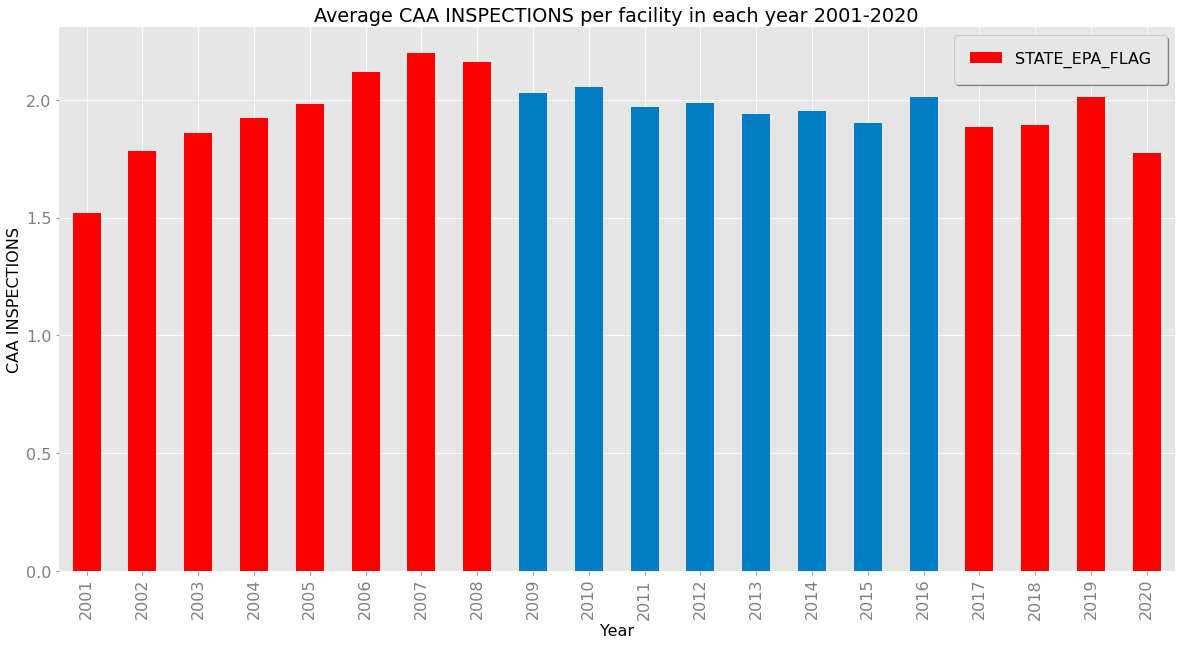

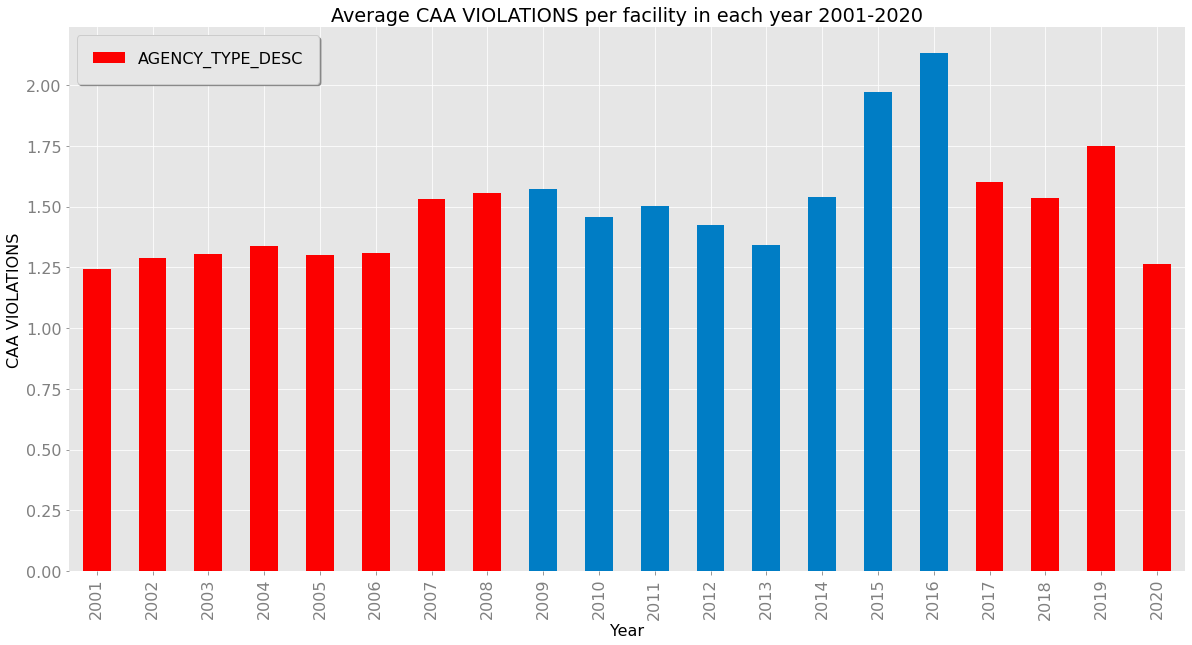

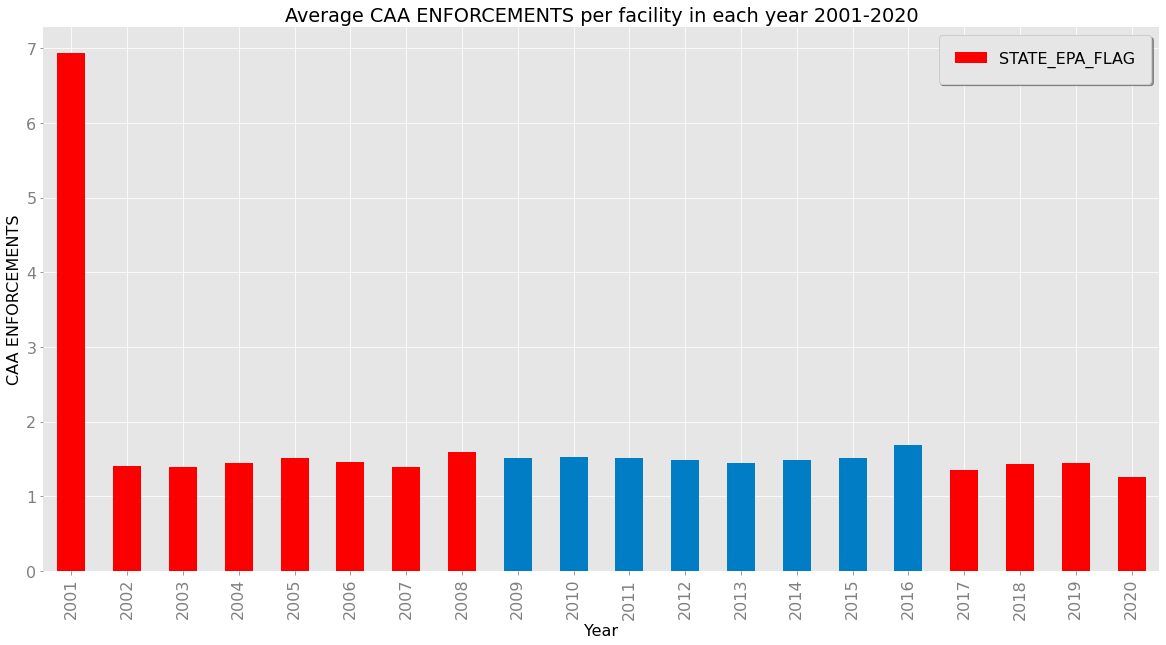

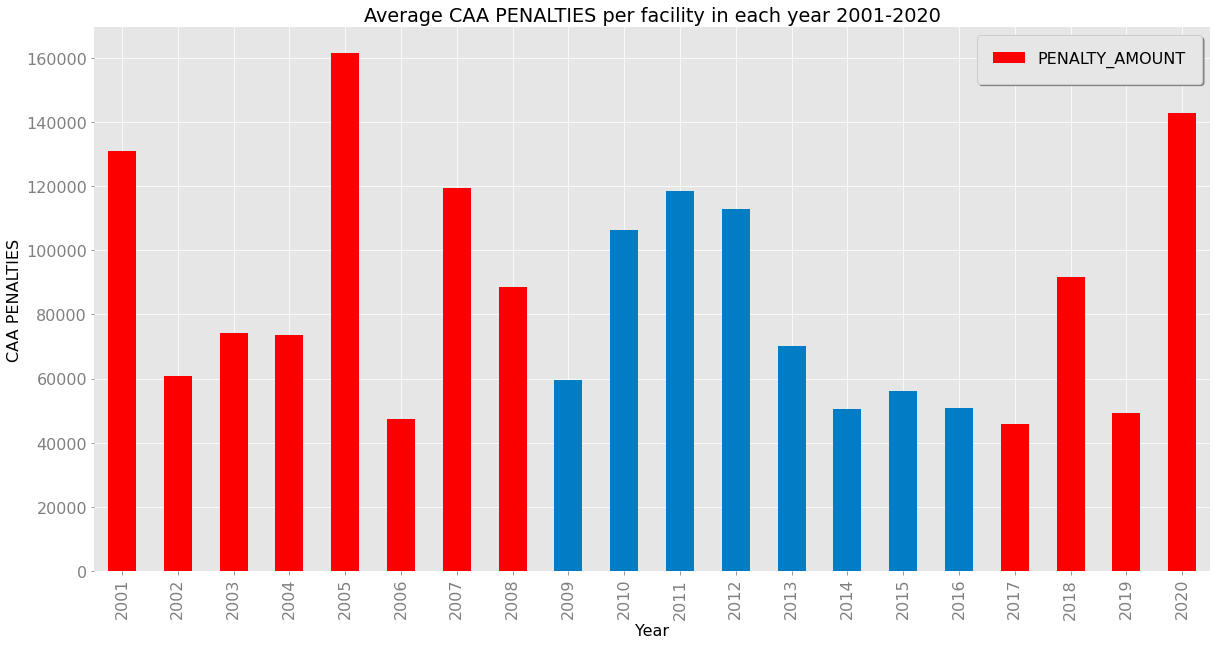

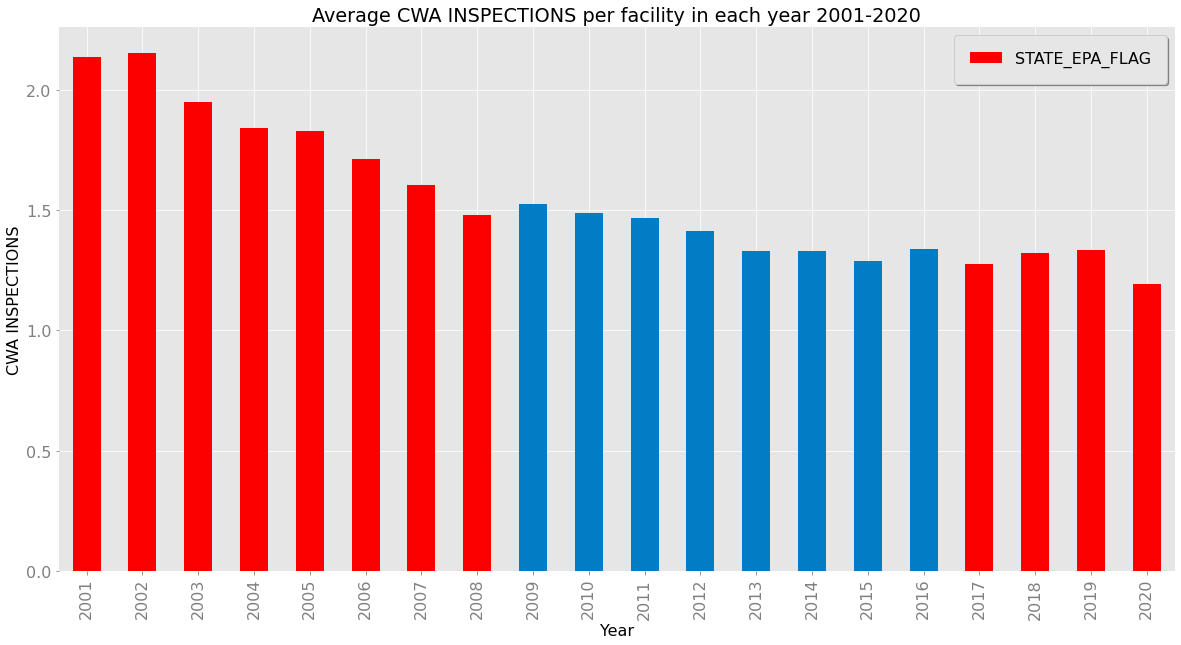

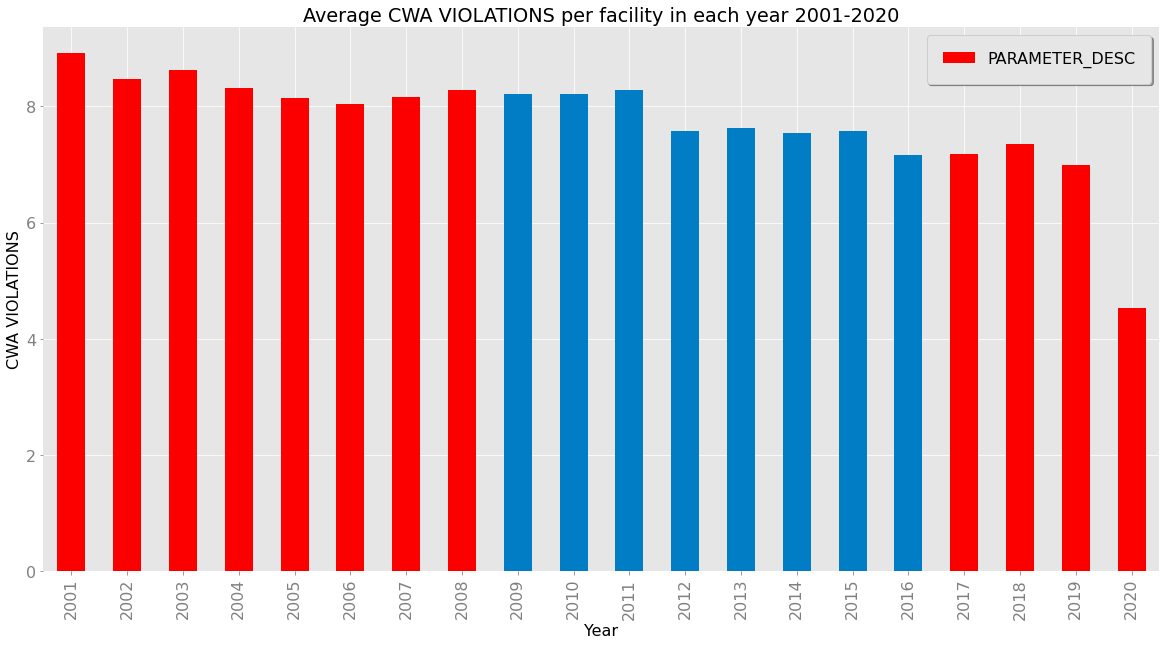

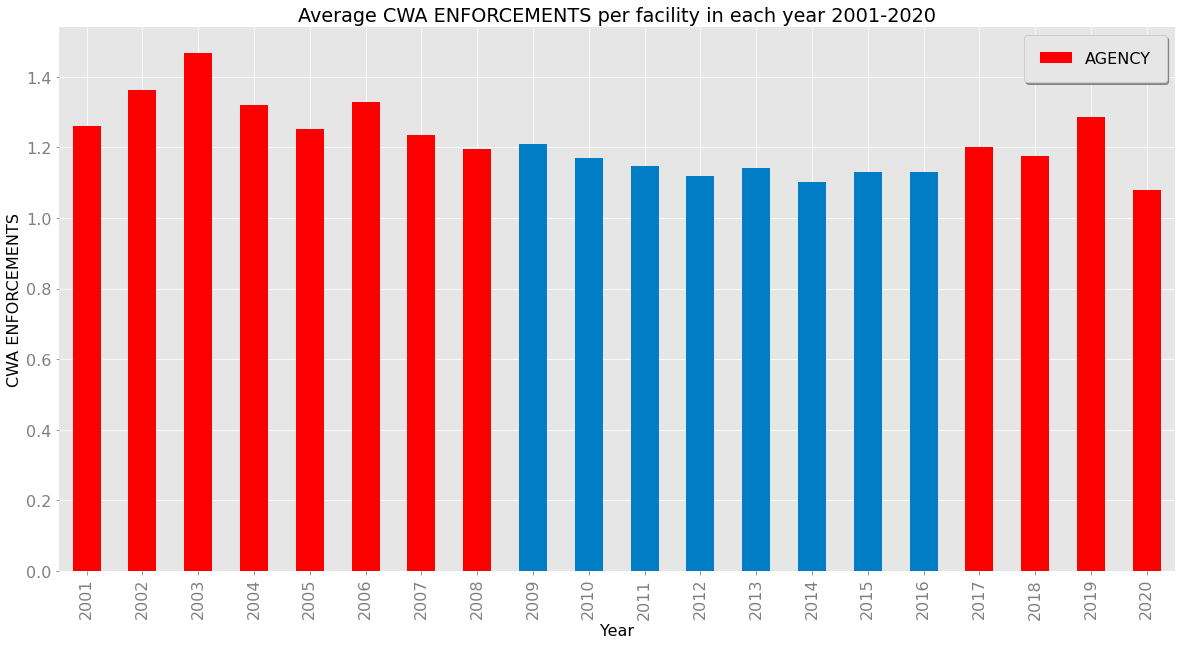

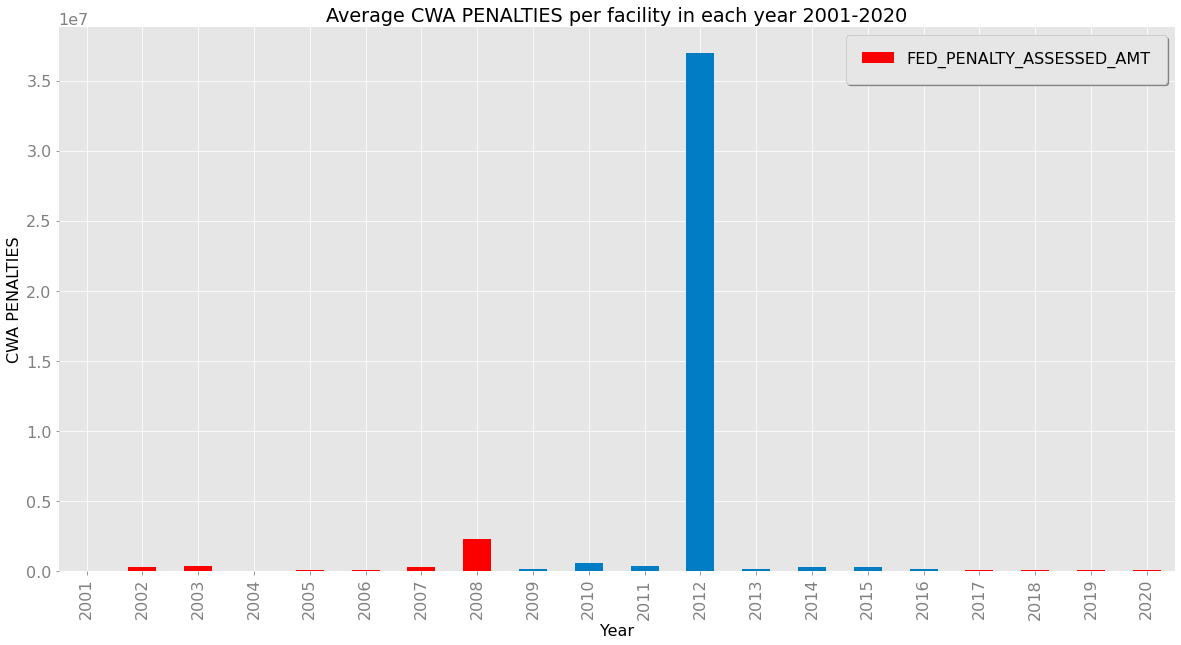

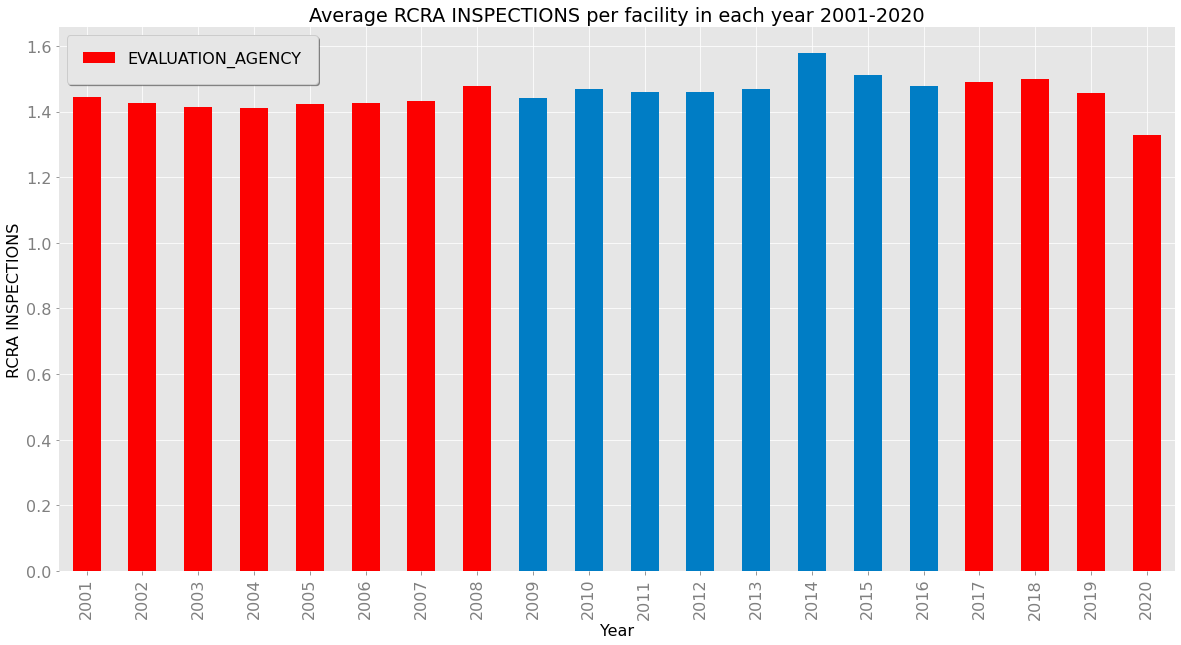

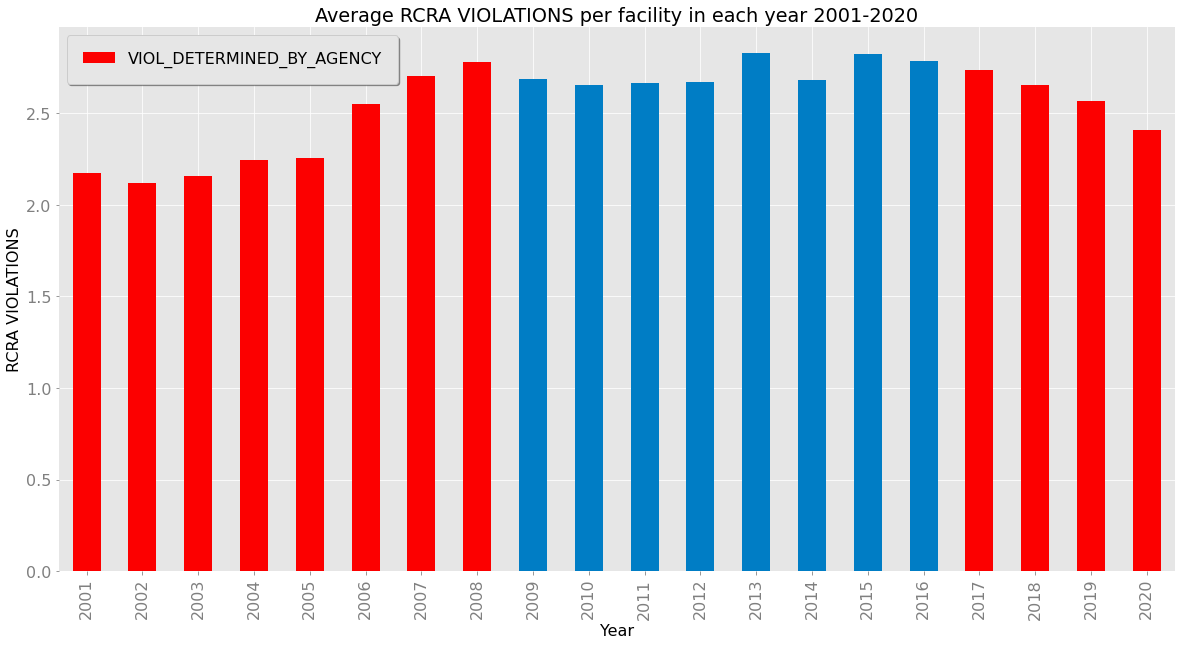

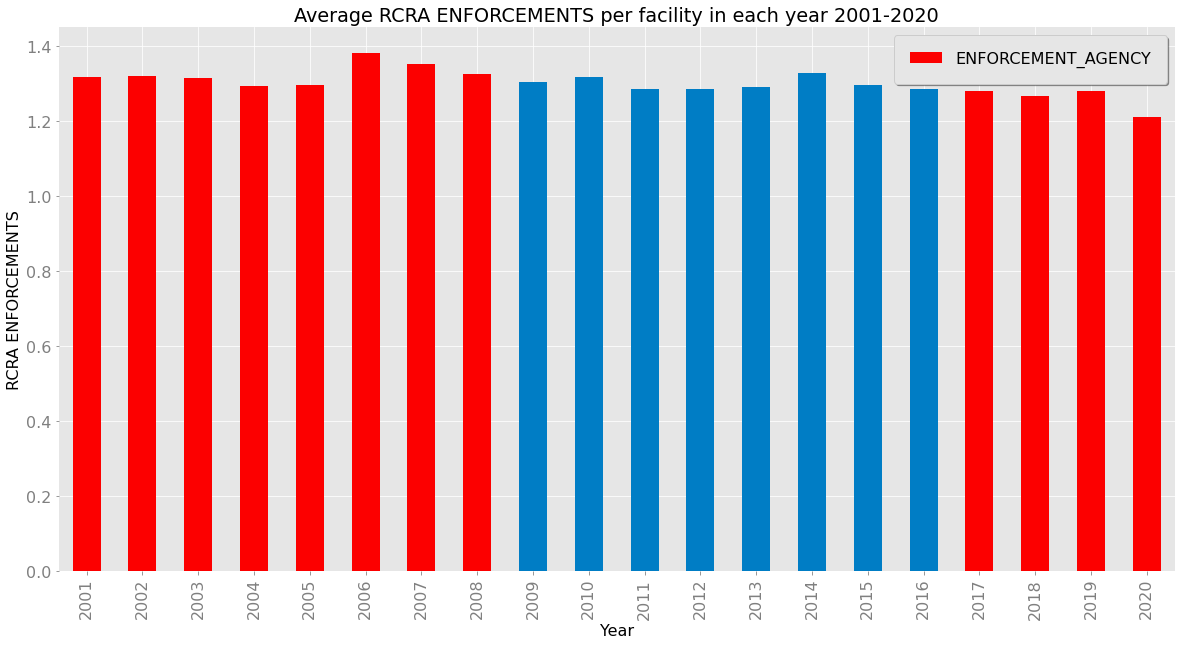

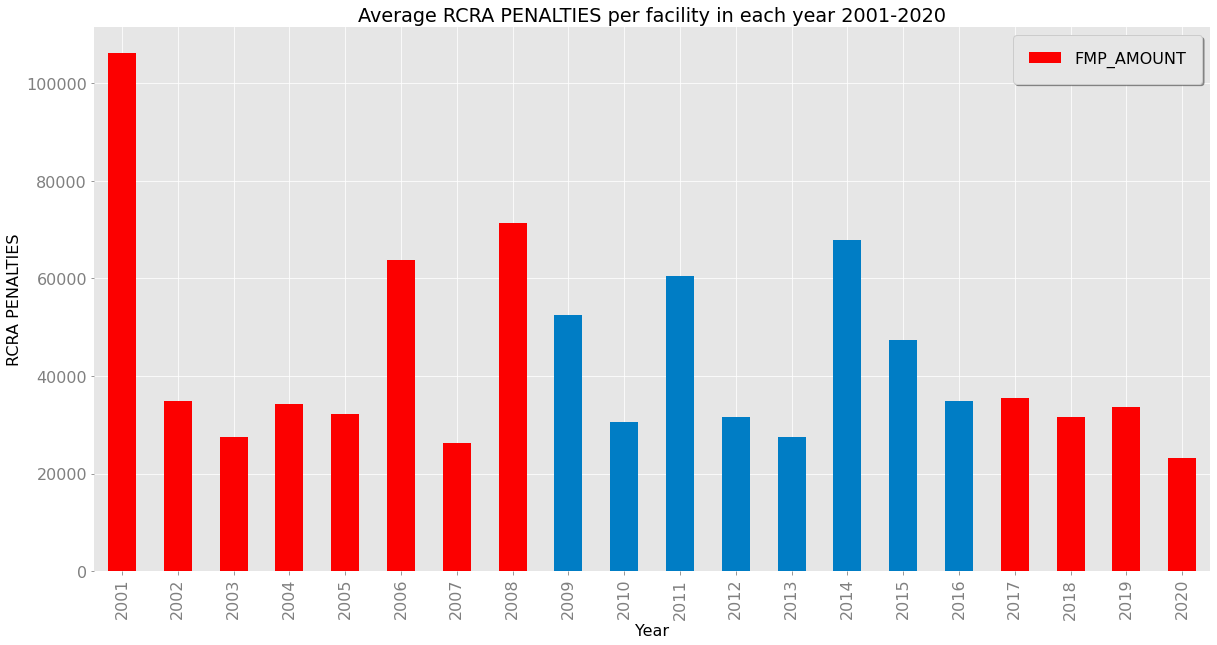

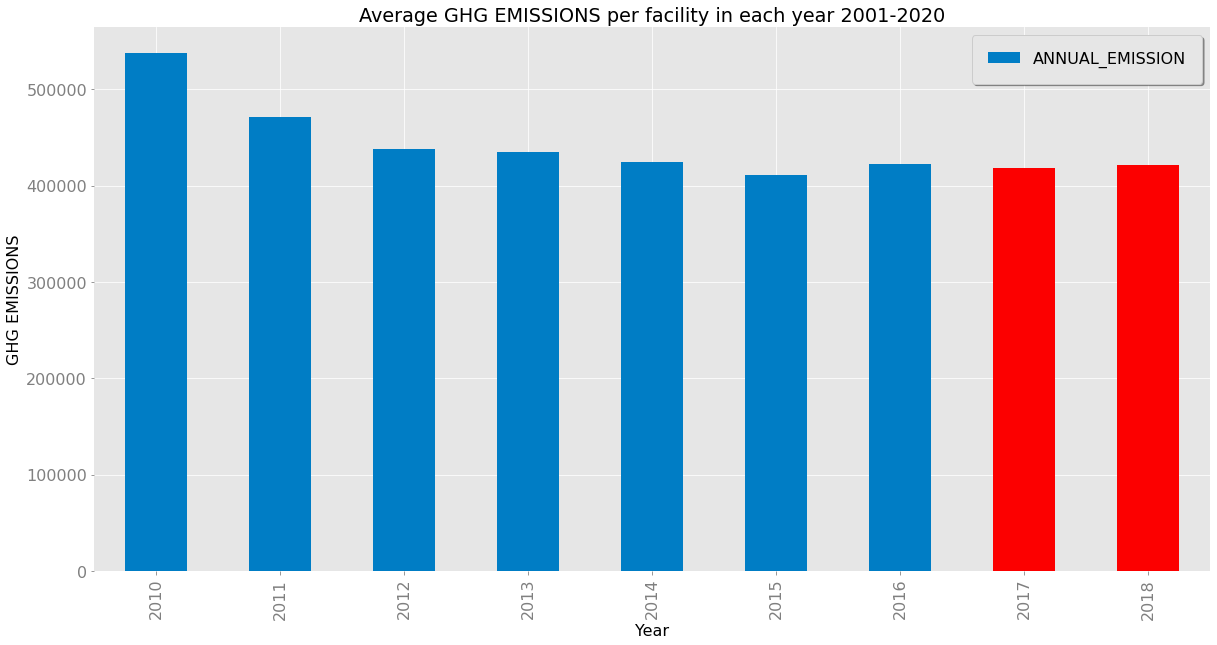

In [ ]:
chart(air_inspections_avg, "inspections", "air_inspections_avg.csv", "CAA INSPECTIONS")
chart(air_violations_avg, "violations", "air_violations_avg.csv", "CAA VIOLATIONS")
chart(air_enforcements_avg, "enforcements", "air_enforcements_avg.csv", "CAA ENFORCEMENTS") # counts enforcement actions, not sum of penalties....
chart(air_penalties_avg, "penalties", "air_penalties_avg.csv", "CAA PENALTIES") # sum of penalties....
chart(water_inspections_avg, "inspections", "water_inspections_avg.csv", "CWA INSPECTIONS")
chart(water_violations_avg, "violations", "water_violations_avg.csv", "CWA VIOLATIONS")
chart(water_enforcements_avg, "enforcements", "water_enforcements_avg.csv", "CWA ENFORCEMENTS") # counts enforcement actions, not sum of penalties....
chart(water_penalties_avg, "penalties", "water_penalties_avg.csv", "CWA PENALTIES") # sum of penalties....FEDERAL amount only
chart(waste_inspections_avg, "inspections", "waste_inspections_avg.csv", "RCRA INSPECTIONS")
chart(waste_violations_avg, "violations", "waste_violations_avg.csv", "RCRA VIOLATIONS")
chart(waste_enforcements_avg,"enforcements", "waste_enforcements_avg.csv", "RCRA ENFORCEMENTS") # counts enforcement actions, not sum of penalties....
chart(waste_penalties_avg, "penalties", "waste_penalties_avg.csv", "RCRA PENALTIES") # sum of penalties....Final monetary penalty - see https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary
chart(ghg_emissions_avg, "emissions", "ghg_emissions_avg.csv", "GHG EMISSIONS")

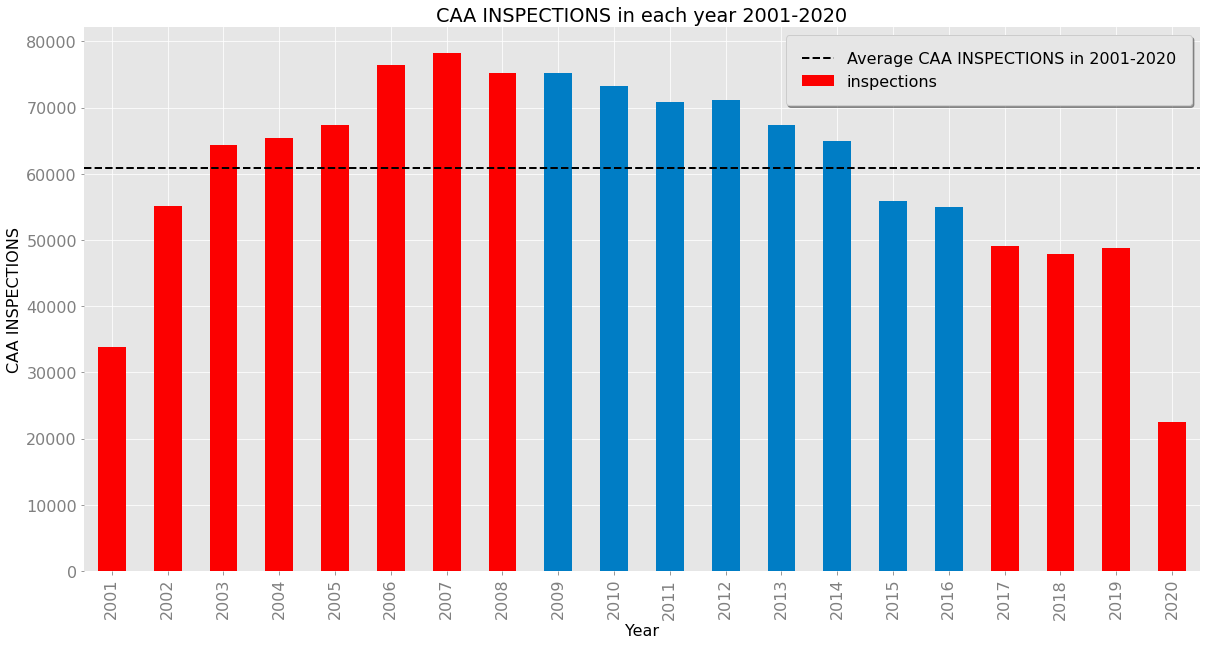

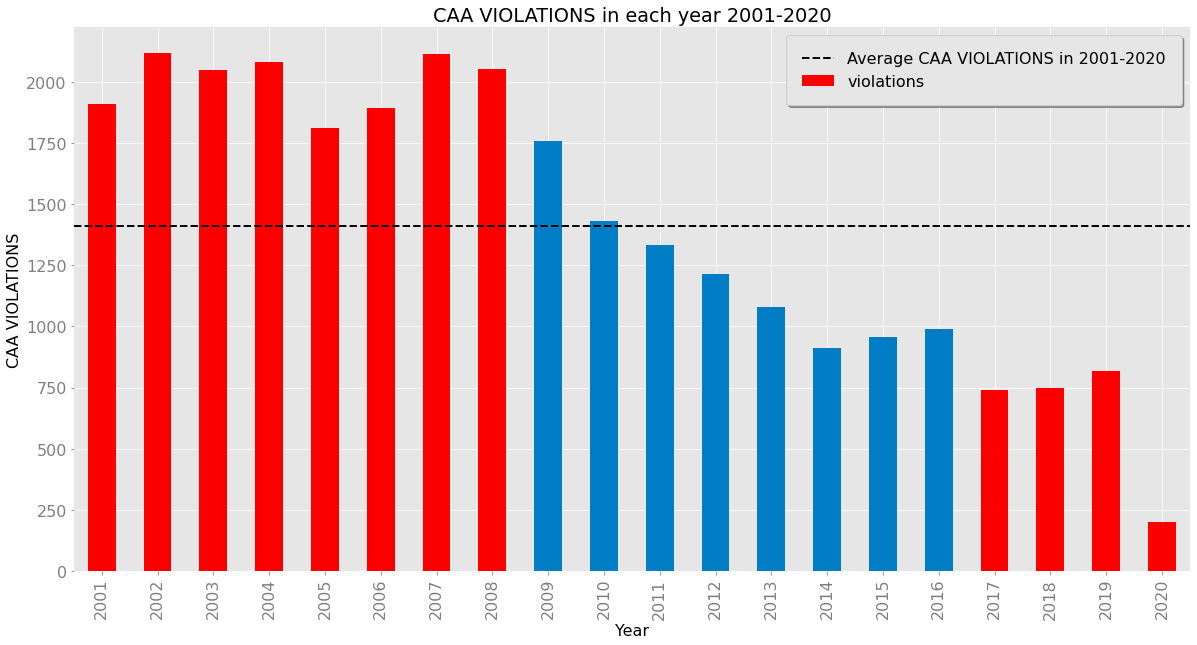

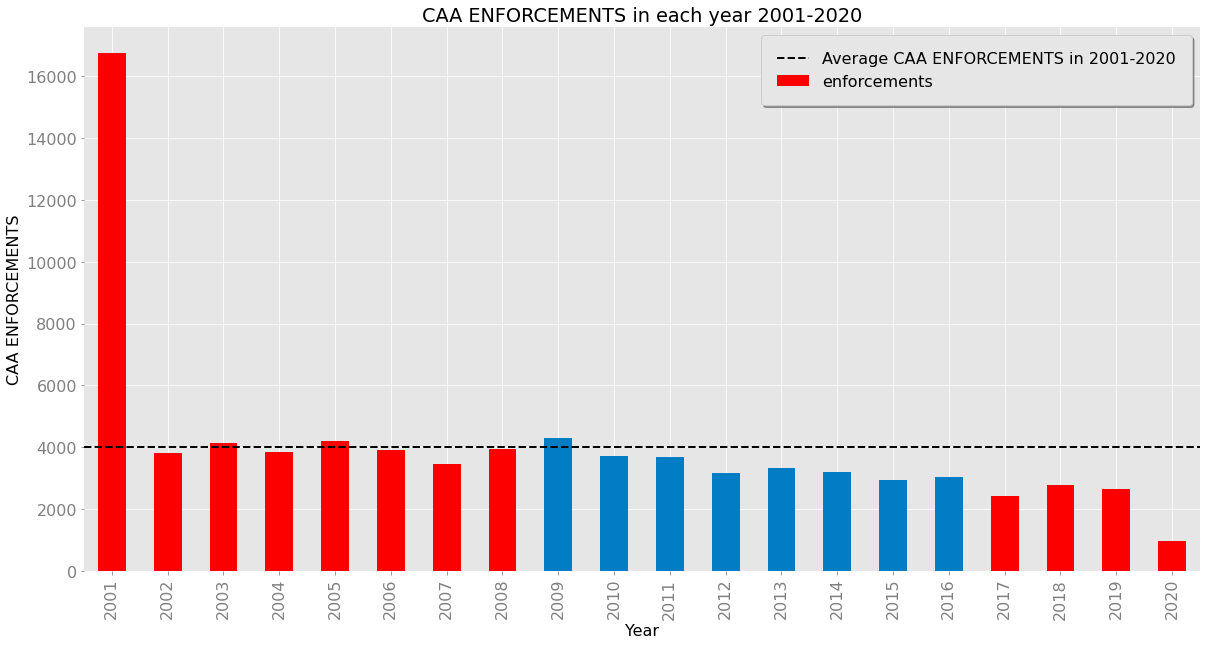

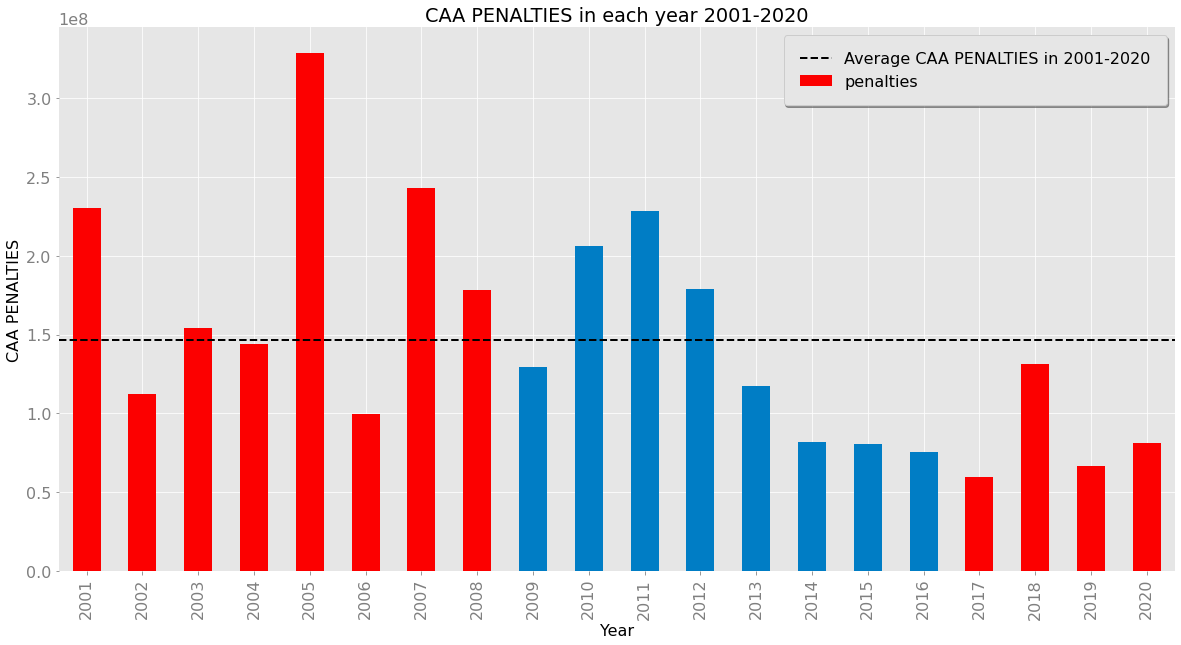

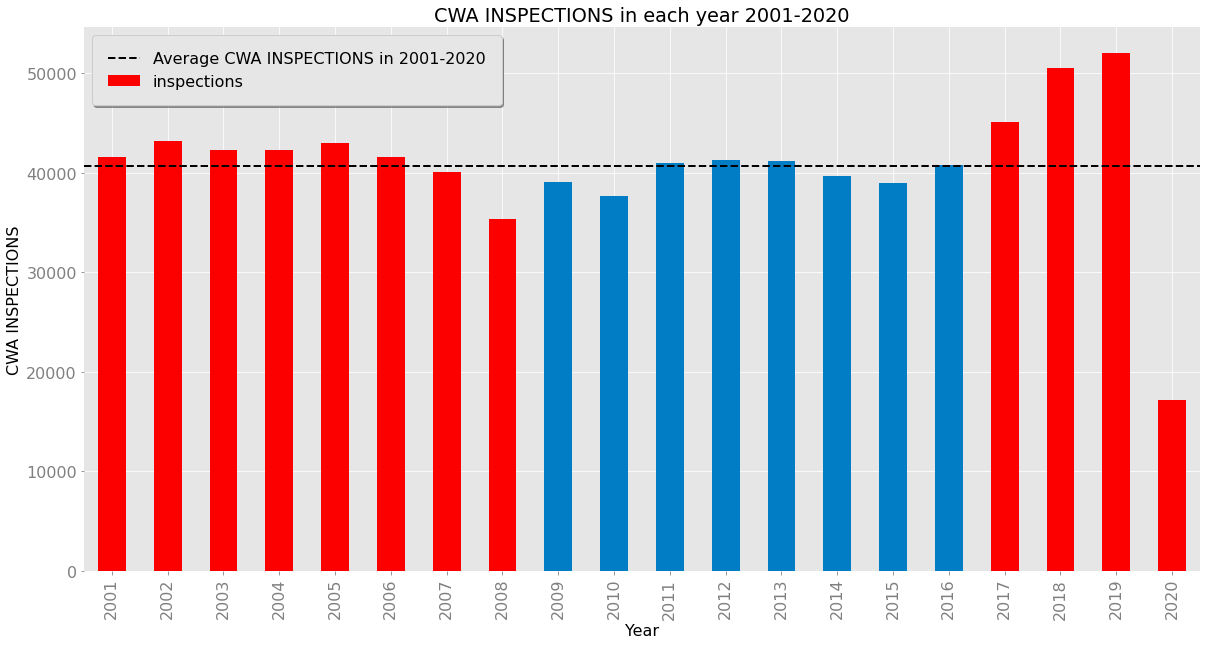

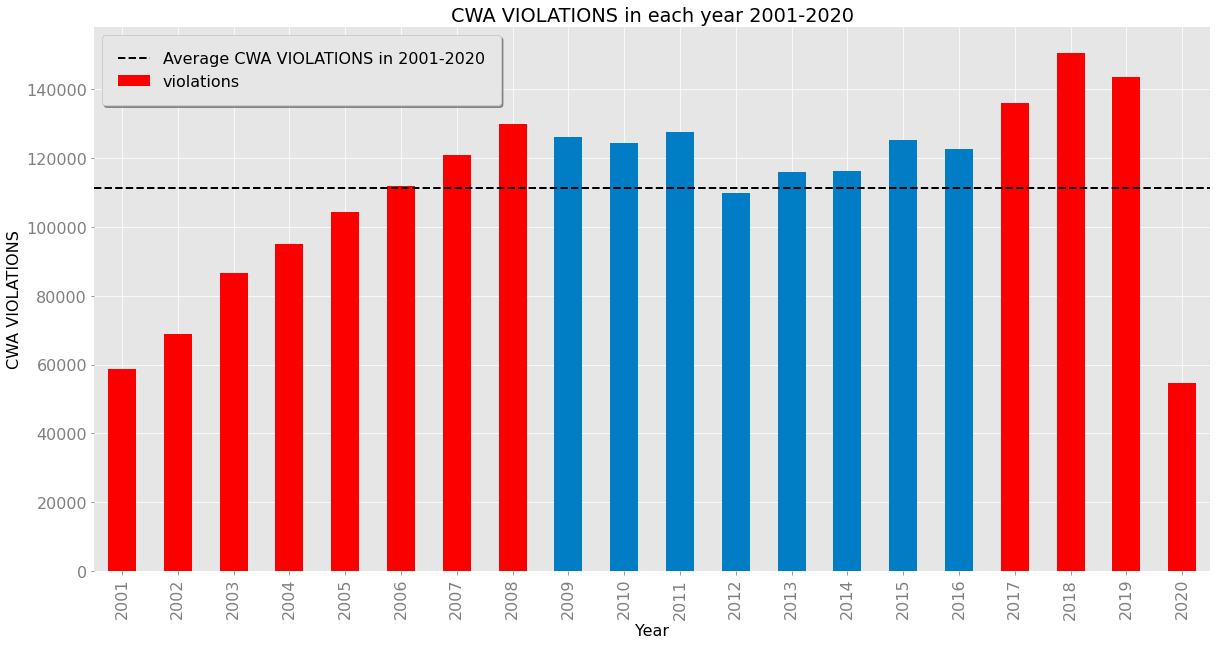

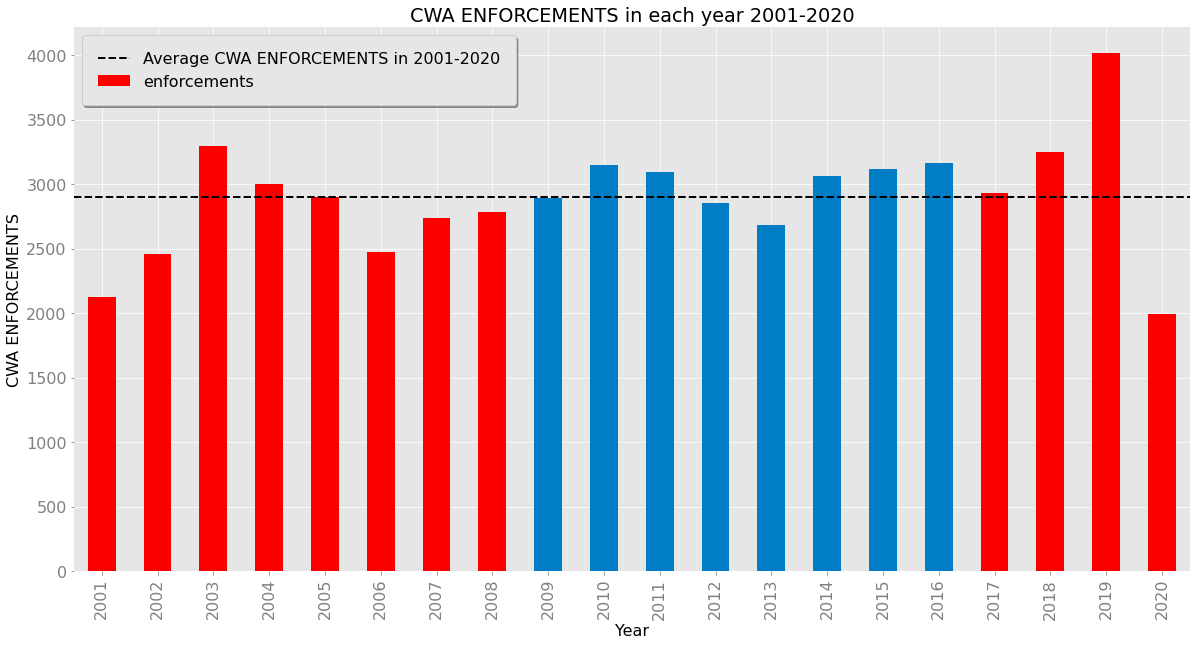

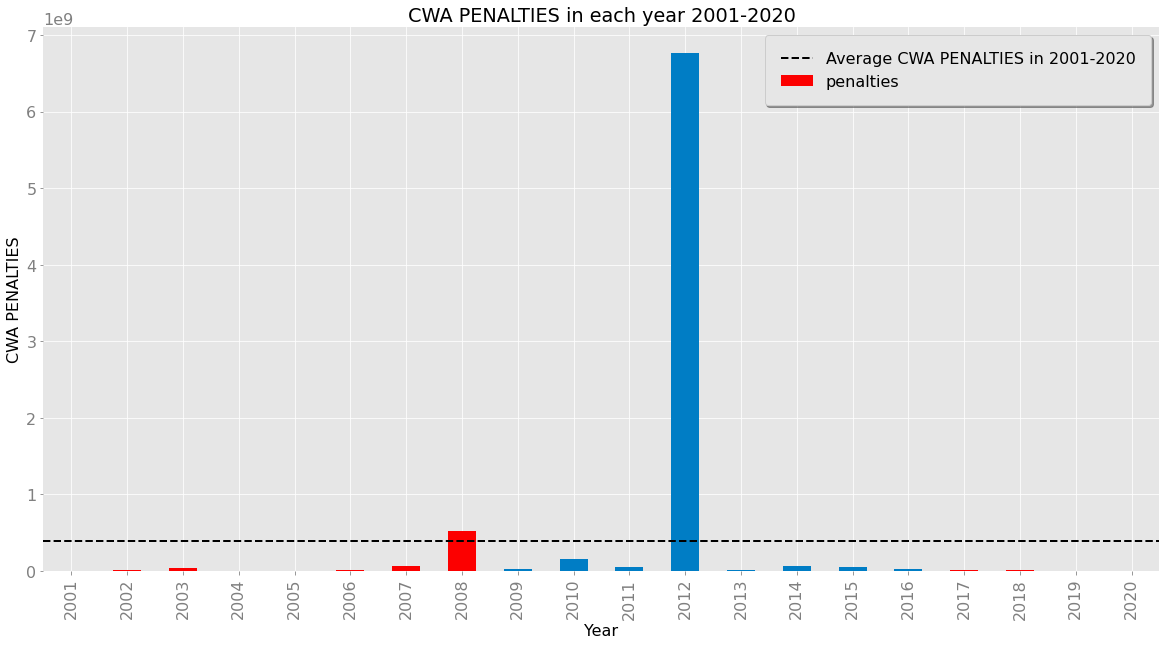

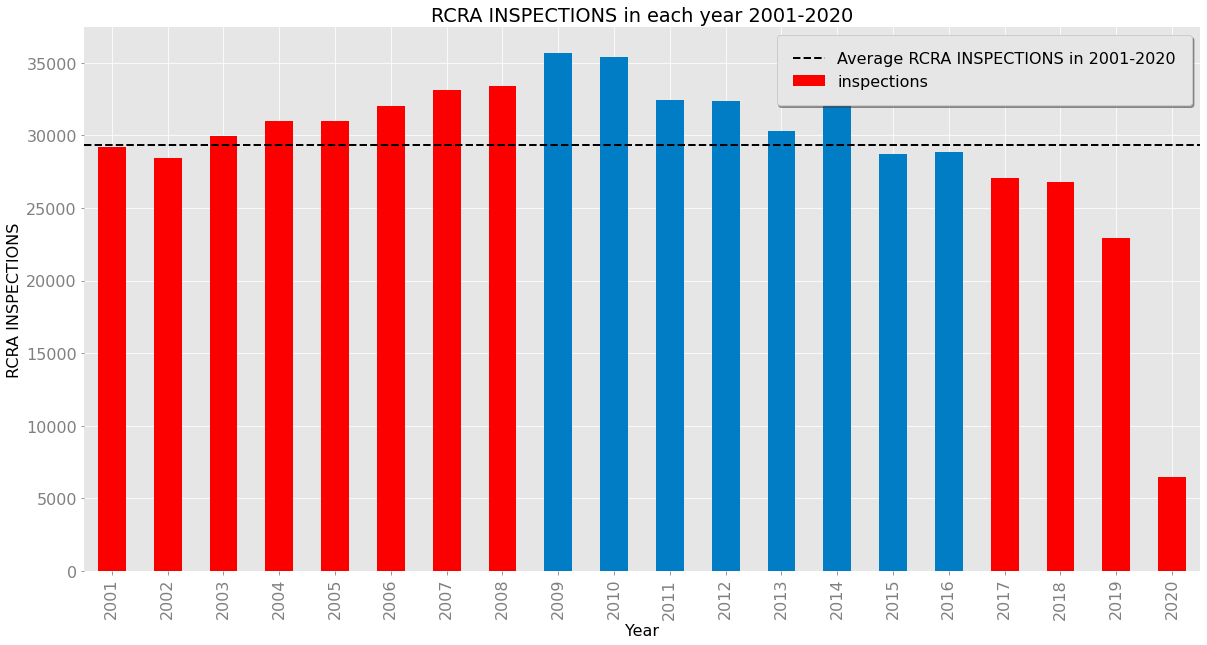

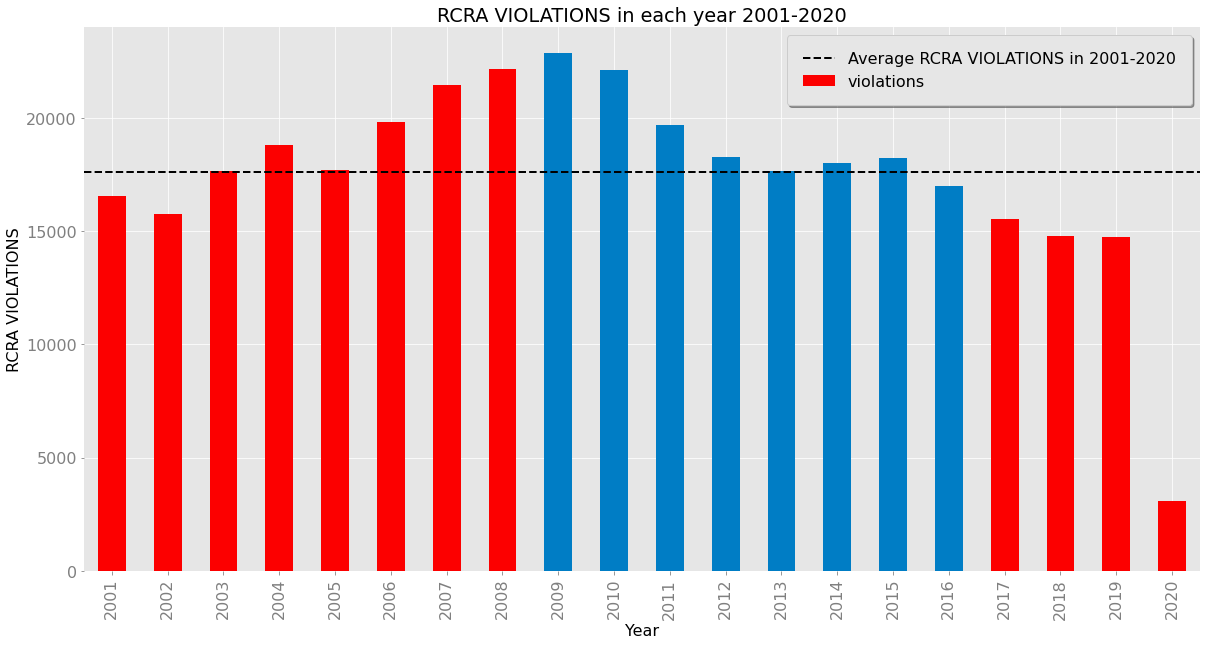

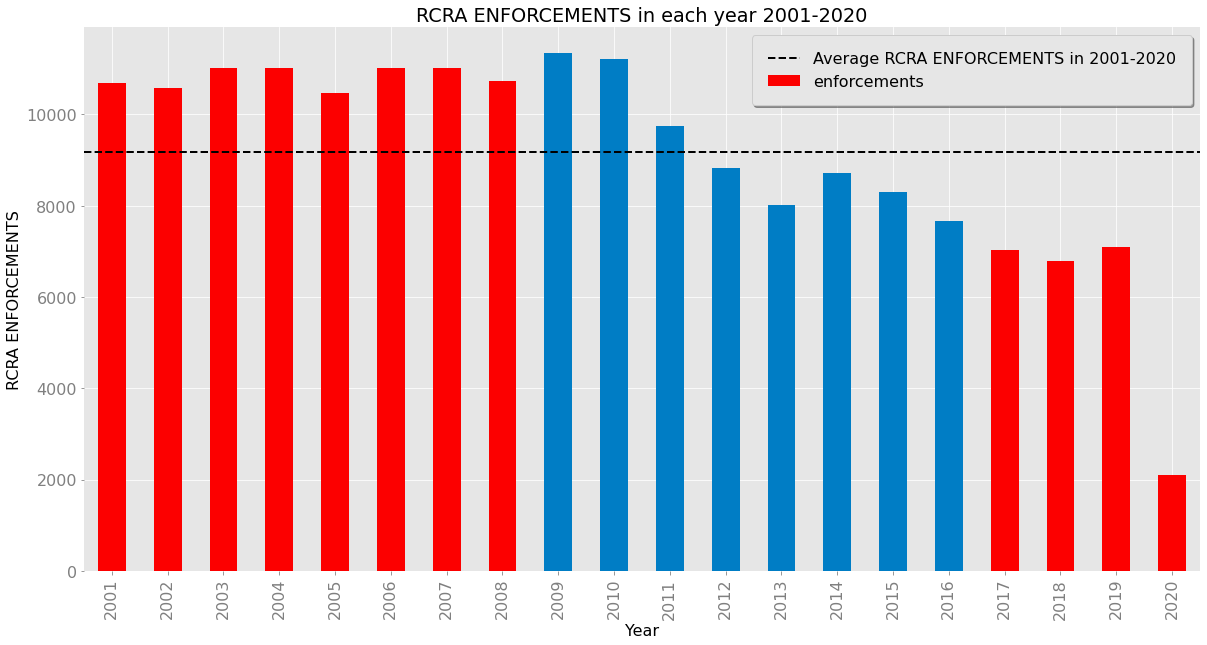

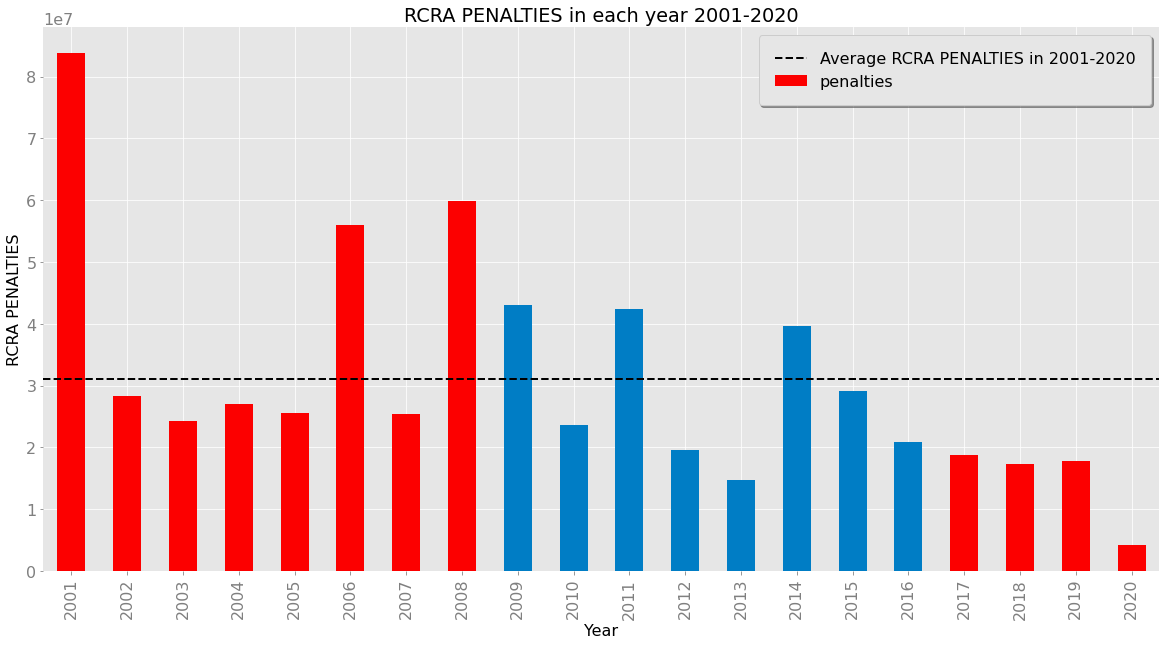

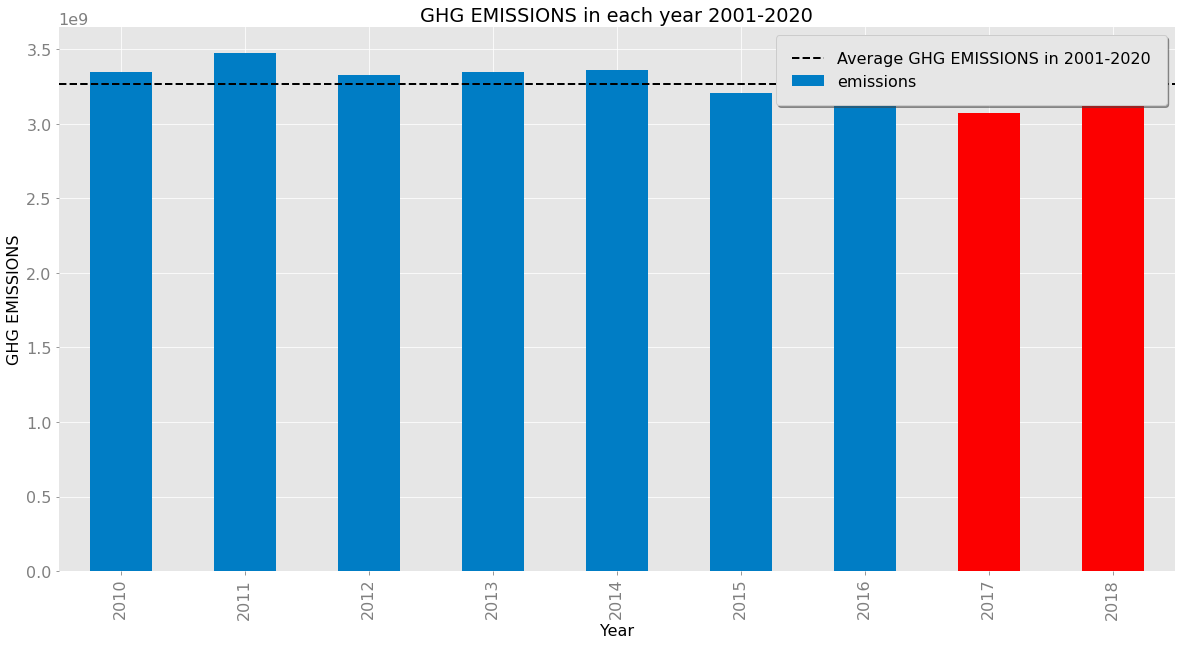

In [ ]:
charter(air_inspections, "ACTUAL_END_DATE", '%m-%d-%Y', "STATE_EPA_FLAG", "inspections", "air_inspections.csv", "CAA INSPECTIONS", "count")
charter(air_violations, "HPV_DAYZERO_DATE", '%m-%d-%Y', "AGENCY_TYPE_DESC", "violations", "air_violations.csv", "CAA VIOLATIONS", "count")
charter(air_enforcements, "SETTLEMENT_ENTERED_DATE", '%m/%d/%Y', "PENALTY_AMOUNT", "enforcements", "air_enforcements.csv", "CAA ENFORCEMENTS", "count") # counts enforcement actions, not sum of penalties....
charter(air_enforcements, "SETTLEMENT_ENTERED_DATE", '%m/%d/%Y', "PENALTY_AMOUNT", "penalties", "air_penalties.csv", "CAA PENALTIES", "sum") # sum of penalties....
charter(water_inspections, "ACTUAL_END_DATE", '%m/%d/%Y', "STATE_EPA_FLAG", "inspections", "water_inspections.csv", "CWA INSPECTIONS", "count")
charter(water_violations, "MONITORING_PERIOD_END_DATE", '%m/%d/%Y', "EXCEEDENCE_PCT", "violations", "water_violations.csv", "CWA VIOLATIONS", "count")
charter(water_enforcements, "SETTLEMENT_ENTERED_DATE", '%m/%d/%Y', "SETTLEMENT_ENTERED_DATE", "enforcements", "water_enforcements.csv", "CWA ENFORCEMENTS", "count") # counts enforcement actions, not sum of penalties....
charter(water_enforcements, "SETTLEMENT_ENTERED_DATE", '%m/%d/%Y', "FED_PENALTY_ASSESSED_AMT", "penalties", "water_penalties.csv", "CWA PENALTIES", "sum") # sum of penalties....FEDERAL amount only
charter(waste_inspections, "EVALUATION_START_DATE", '%m/%d/%Y', "EVALUATION_AGENCY", "inspections", "waste_inspections.csv", "RCRA INSPECTIONS", "count")
charter(waste_violations, "DATE_VIOLATION_DETERMINED", '%m/%d/%Y', "VIOL_DETERMINED_BY_AGENCY", "violations", "waste_violations.csv", "RCRA VIOLATIONS", "count")
charter(waste_enforcements, "ENFORCEMENT_ACTION_DATE", '%m/%d/%Y', "ENFORCEMENT_ACTION_DATE", "enforcements", "waste_enforcements.csv", "RCRA ENFORCEMENTS", "count") # counts enforcement actions, not sum of penalties....
charter(waste_enforcements, "ENFORCEMENT_ACTION_DATE", '%m/%d/%Y', "FMP_AMOUNT", "penalties", "waste_penalties.csv", "RCRA PENALTIES", "sum") # sum of penalties....Final monetary penalty - see https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary
charter(ghg_emissions, "REPORTING_YEAR", '%Y', "ANNUAL_EMISSION", "emissions", "ghg_emissions.csv", "GHG EMISSIONS", "sum")